<a href="https://colab.research.google.com/github/Witcape/PSO/blob/main/Weights_Final_Iterations/ITERATION_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEST

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-zh72s4w3
  Entered build tracker: /tmp/pip-build-tracker-zh72s4w3
  Created temporary directory: /tmp/pip-install-ln3fqvc9
  Created temporary directory: /tmp/pip-ephem-wheel-cache-xgw71njy
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

In [ ]:
# GPU
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

In [ ]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

In [ ]:
CostFunction = sphere  #
nVar = 10  # Number of Decision Variables
VarSize = (nVar,)  # Size of Decision Variables Matrix
VarMin = -10  # Lower Bound of Variables
VarMax = 10  # Upper Bound of Variables

In [ ]:
MaxIt = 20  # Maximum Number of Iterations
nPop = 20

In [ ]:
w = 1  # Inertia Weight
wdamp = 0.99  # Inertia Weight Damping Ratio
c1 = 1.5  # Personal Learning Coefficient
c2 = 2.0  # Global Learning Coefficient

In [ ]:
VelMax = 0.1 * (VarMax - VarMin)
VelMin = -VelMax

In [ ]:
particles = []

for _ in range(nPop):
    position = np.random.uniform(VarMin, VarMax, VarSize)
    velocity = np.zeros(VarSize)
    cost = CostFunction(position)
    best_position = position.copy()
    best_cost = cost
    particles.append({
        'Position': position,
        'Velocity': velocity,
        'Cost': cost,
        'Best': {
            'Position': best_position,
            'Cost': best_cost
        }
    })
print(np.size(particles))

In [ ]:
GlobalBest = {'Position': None, 'Cost': np.inf}

for p in particles:
    if p['Cost'] < GlobalBest['Cost']:
        GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

BestCost = np.zeros(MaxIt)

In [ ]:
w_values = []
g_values = []

for it in range(MaxIt):
    for p in particles:
        # Update Velocity
        r1 = np.random.rand(*VarSize)
        r2 = np.random.rand(*VarSize)
        p['Velocity'] = (
            w * p['Velocity']
            + c1 * r1 * (p['Best']['Position'] - p['Position'])
            + c2 * r2 * (GlobalBest['Position'] - p['Position'])
        )

        # Apply Velocity Limits
        p['Velocity'] = np.maximum(p['Velocity'], VelMin)
        p['Velocity'] = np.minimum(p['Velocity'], VelMax)

        # Update Position
        p['Position'] += p['Velocity']

        # Velocity Mirror Effect
        IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
        p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

        # Apply Position Limits
        p['Position'] = np.maximum(p['Position'], VarMin)
        p['Position'] = np.minimum(p['Position'], VarMax)

        # Evaluation
        p['Cost'] = CostFunction(p['Position'])

        # Update Personal Best
        if p['Cost'] < p['Best']['Cost']:
            p['Best']['Position'] = p['Position'].copy()
            p['Best']['Cost'] = p['Cost']

            # Update Global Best
            if p['Best']['Cost'] < GlobalBest['Cost']:  # tell best cost using roullete wheel. LLM will check for global best
                GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']} # tell best cost using roullete wheel

    BestCost[it] = GlobalBest['Cost']

    print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

    prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
    w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

    USER: {prompt}

    ASSISTANT:
    '''

    w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                          repeat_penalty=1.2, top_k=150,
                          echo=True)

    g_values.append(GlobalBest['Cost'])
    BestCost[it] = GlobalBest['Cost']

    text_response = w_response['choices'][0]['text']
    value = re.findall(r'-?\d+\.\d+', text_response)
    value = [float(num) for num in value]

    value = value[np.size(value) - 1]
    print(f'w{it+1} = {value}')
    w_values.append(w)
    w = value

w_values.append(w)
print(w_values)

# Function

In [1]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.8 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-pm1ooam2
  Entered build tracker: /tmp/pip-build-tracker-pm1ooam2
  Created temporary directory: /tmp/pip-install-lv02n6u4
  Created temporary directory: /tmp/pip-ephem-wheel-cache-ws8fq4or
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  No cache entry available
  Start

In [2]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [3]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt
import time

In [4]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/9.76G [00:00<?, ?B/s]

In [5]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [6]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.3 MB/s eta 0:00:00


In [7]:
import numpy as np
import re

def run_pso(
    CostFunction, nVar=10, VarMin=-10, VarMax=10, MaxIt=20, nPop=500,
    w=1, wdamp=0.99, c1=2.05, c2=2.05, n_threads=2, n_batch=512, n_gpu_layers=32, chi=0.729843788
):
    VarSize = (nVar,)
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax

    particles = []

    for _ in range(nPop):
        position = np.random.uniform(VarMin, VarMax, VarSize)
        velocity = np.zeros(VarSize)
        cost = CostFunction(position)
        best_position = position.copy()
        best_cost = cost
        particles.append({
            'Position': position,
            'Velocity': velocity,
            'Cost': cost,
            'Best': {
                'Position': best_position,
                'Cost': best_cost
            }
        })

    GlobalBest = {'Position': None, 'Cost': np.inf}

    for p in particles:
        if p['Cost'] < GlobalBest['Cost']:
            GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

    BestCost = np.zeros(MaxIt)
    w_values = []
    g_values = []

    for it in range(MaxIt):
        for p in particles:
            r1 = np.random.rand(*VarSize)
            r2 = np.random.rand(*VarSize)
            p['Velocity'] = chi * (
                p['Velocity']
                + c1 * r1 * (p['Best']['Position'] - p['Position'])
                + c2 * r2 * (GlobalBest['Position'] - p['Position'])
            )

            # Apply Velocity Limits
            p['Velocity'] = np.maximum(p['Velocity'], VelMin)
            p['Velocity'] = np.minimum(p['Velocity'], VelMax)

            # Update Position
            p['Position'] += p['Velocity']

            # Velocity Mirror Effect
            IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
            p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

            # Apply Position Limits
            p['Position'] = np.maximum(p['Position'], VarMin)
            p['Position'] = np.minimum(p['Position'], VarMax)

            # Evaluation
            p['Cost'] = CostFunction(p['Position'])

            # Update Personal Best
            if p['Cost'] < p['Best']['Cost']:
                p['Best']['Position'] = p['Position'].copy()
                p['Best']['Cost'] = p['Cost']

                # Update Global Best
                if p['Best']['Cost'] < GlobalBest['Cost']:
                    GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}


        BestCost[it] = GlobalBest['Cost']
        print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

        if(it <= 20):
          prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
          w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

          USER: {prompt}

          ASSISTANT:
          '''

          w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                                repeat_penalty=1.2, top_k=150, echo=True)

          text_response = w_response['choices'][0]['text']
          value = re.findall(r'-?\d+\.\d+', text_response)
          value = [float(num) for num in value]

          if value:
              w = value[-1]
              print(f"w{it+1} = {w}")
          else:
              print("Warning: LLM failed to provide a valid weight. Retaining previous weight.")

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

        else:
          w *= wdamp

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

    w_values.append(w)
    print("Final Weights:", w_values)
    return BestCost, w_values, g_values

In [8]:
# def sphere(x):
#     return sum(x**2)

In [9]:
# BestCost, w_values, g_values = run_pso(CostFunction=sphere)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# GNBG class definition
class GNBG:
    def __init__(self, MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition):
        self.MaxEvals = MaxEvals
        self.AcceptanceThreshold = AcceptanceThreshold
        self.Dimension = Dimension
        self.CompNum = CompNum
        self.MinCoordinate = MinCoordinate
        self.MaxCoordinate = MaxCoordinate
        self.CompMinPos = CompMinPos
        self.CompSigma = CompSigma
        self.CompH = CompH
        self.Mu = Mu
        self.Omega = Omega
        self.Lambda = Lambda
        self.RotationMatrix = RotationMatrix
        self.OptimumValue = OptimumValue
        self.OptimumPosition = OptimumPosition
        self.FEhistory = []
        self.FE = 0
        self.BestFoundPosition = None
        self.AcceptanceReachPoint = np.inf
        self.BestFoundResult = np.inf


    def fitness(self, X):
        if len(X.shape)<2:
            X = X.reshape(1,-1)
        SolutionNumber = X.shape[0]
        result = np.nan * np.ones(SolutionNumber)
        for jj in range(SolutionNumber):
            x = X[jj, :].reshape(-1, 1)  # Ensure column vector
            f = np.nan * np.ones(self.CompNum)
            for k in range(self.CompNum):
                if len(self.RotationMatrix.shape) == 3:
                    rotation_matrix = self.RotationMatrix[:, :, k]
                else:
                    rotation_matrix = self.RotationMatrix

                a = self.transform((x - self.CompMinPos[k, :].reshape(-1, 1)).T @ rotation_matrix.T, self.Mu[k, :], self.Omega[k, :])
                b = self.transform(rotation_matrix @ (x - self.CompMinPos[k, :].reshape(-1, 1)), self.Mu[k, :], self.Omega[k, :])
                f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]

            result[jj] = np.min(f)
            if self.FE > (self.MaxEvals-1):
                return result
            self.FE += 1
            self.FEhistory = np.append(self.FEhistory, result[jj])
            if self.BestFoundResult > result[jj]:
                self.BestFoundResult = result[jj]
            if abs(self.FEhistory[self.FE-1] - self.OptimumValue) < self.AcceptanceThreshold and np.isinf(self.AcceptanceReachPoint):
                self.AcceptanceReachPoint = self.FE
        return result
    def transform(self, X, Alpha, Beta):
        Y = X.copy()
        tmp = (X > 0)
        Y[tmp] = np.log(X[tmp])
        Y[tmp] = np.exp(Y[tmp] + Alpha[0] * (np.sin(Beta[0] * Y[tmp]) + np.sin(Beta[1] * Y[tmp])))
        tmp = (X < 0)
        Y[tmp] = np.log(-X[tmp])
        Y[tmp] = -np.exp(Y[tmp] + Alpha[1] * (np.sin(Beta[2] * Y[tmp]) + np.sin(Beta[3] * Y[tmp])))
        return Y

In [11]:
# ProblemIndex = 22  # Choose a problem instance from 1 to 24
# folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat

# # Load GNBG data for the selected problem instance
# if 1 <= ProblemIndex <= 24:
#     filename = f'f{ProblemIndex}.mat'
#     GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']
#     MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
#     AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
#     Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
#     CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
#     MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
#     MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
#     CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
#     CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
#     CompH = np.array(GNBG_tmp['Component_H'][0, 0])
#     Mu = np.array(GNBG_tmp['Mu'][0, 0])
#     Omega = np.array(GNBG_tmp['Omega'][0, 0])
#     Lambda = np.array(GNBG_tmp['lambda'][0, 0])
#     RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
#     OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
#     OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])
# else:
#     raise ValueError('ProblemIndex must be between 1 and 24.')

# # Initialize GNBG problem instance
# gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)
# popsize = 500000
# print(MaxEvals // popsize)

In [12]:
# nVar = Dimension
# VarMin = MinCoordinate
# VarMax = MaxCoordinate
# popsize = 500000
# nPop = 100
# maxiter = MaxEvals // popsize

# BestCost, w_values, g_values, milestone_results = run_pso(
#     CostFunction=gnbg.fitness,
#     nVar=nVar,
#     VarMin=VarMin,
#     VarMax=VarMax,
#     MaxIt=maxiter,
#     nPop=nPop
# )

In [13]:
# milestone_means = {}
# milestone_stds = {}

# for milestone, costs in milestone_results.items():
#     if costs:  # Check if there are any results for this milestone
#         mean_cost = np.mean(costs)
#         std_cost = np.std(costs)
#         milestone_means[milestone] = mean_cost
#         milestone_stds[milestone] = std_cost
#         print(f"At {milestone} function evaluations - Mean Cost: {mean_cost}, Std Dev: {std_cost}")

# # Plot milestone results: Mean cost with standard deviation error bars
# milestones_sorted = sorted(milestone_means.keys())
# means = [milestone_means[m] for m in milestones_sorted]
# stds = [milestone_stds[m] for m in milestones_sorted]

# plt.errorbar(milestones_sorted, means, yerr=stds, fmt='o', color='b', capsize=5)
# plt.xlabel('Function Evaluations')
# plt.ylabel('Cost')
# plt.title('Cost vs Function Evaluations with Std Dev')
# plt.show()

In [14]:
# plt.plot(w_values)
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations')
# plt.show()

In [15]:
# plt.plot(g_values)
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations')
# plt.show()

In [16]:
# # Print best cost and best position
# print("Best Cost Found by PSO:\n\n", BestCost)

# # Print the position corresponding to the best cost
# print("\n\nBest Position:", g_values[-1])

# RUN ALL ALGOS

In [17]:
costs = []
errors = []

In [18]:
def run_all_problems(folder_path, num_problems=24):
    all_results = {}

    for problem_index in range(1, num_problems + 1):
        start_time = time.time()

        filename = f'f{problem_index}.mat'
        GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']

        MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
        AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
        Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
        CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
        MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
        MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
        CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
        CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
        CompH = np.array(GNBG_tmp['Component_H'][0, 0])
        Mu = np.array(GNBG_tmp['Mu'][0, 0])
        Omega = np.array(GNBG_tmp['Omega'][0, 0])
        Lambda = np.array(GNBG_tmp['lambda'][0, 0])
        RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
        OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
        OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])


        # Initialize GNBG problem instance
        gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)

        # Run PSO for the current problem
        nVar = Dimension
        VarMin = MinCoordinate
        VarMax = MaxCoordinate
        # MaxEvals = 500000
        nPop = 100
        # maxiter = MaxEvals // nPop
        maxiter = 500

        BestCost, w_values, g_values = run_pso(
            CostFunction=gnbg.fitness,
            nVar=nVar,
            VarMin=VarMin,
            VarMax=VarMax,
            MaxIt=maxiter,
            nPop=nPop
        )

        error = abs(BestCost[-1] - gnbg.OptimumValue)

        # Add error to results dictionary
        all_results[problem_index] = {
            'BestCost': BestCost,
            'BestPosition': g_values[-1],
            'w_values': w_values,
            'g_values': g_values,
            'OptimumValue': gnbg.OptimumValue,
            'Error': error
        }
        end_time = time.time()
        iteration_time = end_time - start_time

        print(f"Problem {problem_index} Best Cost:", BestCost)
        print(f"Problem {problem_index} Error:", error)
        print(f"Problem {problem_index} Time Taken: {iteration_time:.4f} seconds")


    return all_results

In [20]:
# Run for all 24 problems
folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat
results = run_all_problems(folder_path)

for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['BestPosition'])
    costs.append(problem_results['BestPosition'])

# # Example of how to access results for a particular problem
# problem_1_results = results[1]
# print("\n\n\nProblem 1 Best Cost:", problem_1_results['BestCost'])
# print("Problem 1 Best Position:", problem_1_results['BestPosition'])
# print("Problem 1 Error:", problem_1_results['Error'])

# # Plotting results for one of the problems (e.g., Problem 1)
# plt.plot(problem_1_results['w_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations - Problem 1')
# plt.show()

# plt.plot(problem_1_results['g_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations - Problem 1')
# plt.show()


<ipython-input-10-920e6cc4fb83>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]
<ipython-input-7-2d427eabae00>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BestCost[it] = GlobalBest['Cost']


Iteration 1: Best Cost = 68656.09452875315
w1 = 0.23456789
Iteration 2: Best Cost = 49293.042263384035


Llama.generate: prefix-match hit


w2 = 0.22987654
Iteration 3: Best Cost = 37095.16001153592


Llama.generate: prefix-match hit


w3 = 0.21345678
Iteration 4: Best Cost = 29943.717962402377


Llama.generate: prefix-match hit


w4 = 0.19523456
Iteration 5: Best Cost = 26113.37236598885


Llama.generate: prefix-match hit


w5 = 0.17823456
Iteration 6: Best Cost = 16854.80616100337


Llama.generate: prefix-match hit


w6 = 0.16982789
Iteration 7: Best Cost = 10788.405759832316


Llama.generate: prefix-match hit


w7 = 0.15432789
Iteration 8: Best Cost = 9286.826007082489


Llama.generate: prefix-match hit


w8 = 0.1456789
Iteration 9: Best Cost = 6282.415233397487


Llama.generate: prefix-match hit


w9 = 0.132456789
Iteration 10: Best Cost = 5685.906434189257


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 3778.570099057999


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 3235.071307055907


Llama.generate: prefix-match hit


w12 = 0.109
Iteration 13: Best Cost = 2565.3669712677674


Llama.generate: prefix-match hit


w13 = 0.087
Iteration 14: Best Cost = 2342.577637540304


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = 1563.639464564834


Llama.generate: prefix-match hit


w15 = 0.085
Iteration 16: Best Cost = 1362.8499357443004


Llama.generate: prefix-match hit


w16 = 0.079
Iteration 17: Best Cost = 877.7608805941568


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = 687.8134425978842


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 646.860630233823


Llama.generate: prefix-match hit


w19 = 0.065
Iteration 20: Best Cost = 583.7892199090379


Llama.generate: prefix-match hit


w20 = 0.073
Iteration 21: Best Cost = 386.5642917907462


Llama.generate: prefix-match hit


w21 = 0.065
Iteration 22: Best Cost = 335.9131039375527
Iteration 23: Best Cost = -50.871900225771014
Iteration 24: Best Cost = -112.46845254607422
Iteration 25: Best Cost = -112.46845254607422
Iteration 26: Best Cost = -112.46845254607422
Iteration 27: Best Cost = -190.04308178245185
Iteration 28: Best Cost = -190.04308178245185
Iteration 29: Best Cost = -316.98350157421123
Iteration 30: Best Cost = -541.0996604451801
Iteration 31: Best Cost = -570.1810209660348
Iteration 32: Best Cost = -570.1810209660348
Iteration 33: Best Cost = -688.3703782180555
Iteration 34: Best Cost = -688.3703782180555
Iteration 35: Best Cost = -710.9898556950963
Iteration 36: Best Cost = -710.9898556950963
Iteration 37: Best Cost = -710.9898556950963
Iteration 38: Best Cost = -710.9898556950963
Iteration 39: Best Cost = -753.0088718455443
Iteration 40: Best Cost = -801.7051062757953
Iteration 41: Best Cost = -801.7051062757953
Iteration 42: Best Cost = -801.7051062757953
Iteration 43: Best Cost = -823.087427

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = -701.4109990607004


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = -701.4334609928064


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = -701.4423512534049


Llama.generate: prefix-match hit


w4 = 0.23
Iteration 5: Best Cost = -701.4667227917281


Llama.generate: prefix-match hit


w5 = 0.19
Iteration 6: Best Cost = -701.4984117685143


Llama.generate: prefix-match hit


w6 = 0.175
Iteration 7: Best Cost = -701.5203162513138


Llama.generate: prefix-match hit


w7 = 0.148
Iteration 8: Best Cost = -701.5488870417109


Llama.generate: prefix-match hit


w8 = 0.135
Iteration 9: Best Cost = -701.5493625373861


Llama.generate: prefix-match hit


w9 = 0.127
Iteration 10: Best Cost = -701.5567519875464


Llama.generate: prefix-match hit


w10 = 0.119
Iteration 11: Best Cost = -701.5696616187658


Llama.generate: prefix-match hit


w11 = 0.105
Iteration 12: Best Cost = -701.6043340063479


Llama.generate: prefix-match hit


w12 = 0.097
Iteration 13: Best Cost = -701.6208501563696


Llama.generate: prefix-match hit


w13 = 0.085
Iteration 14: Best Cost = -701.6249405338763


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = -701.6249405338763


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = -701.6282641492562


Llama.generate: prefix-match hit


w16 = 0.094
Iteration 17: Best Cost = -701.6680275221858


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = -701.6680275221858


Llama.generate: prefix-match hit


w18 = 0.094
Iteration 19: Best Cost = -701.6778264387309


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = -701.7070546549345


Llama.generate: prefix-match hit


w20 = 0.094
Iteration 21: Best Cost = -701.7070546549345


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = -701.7304349435207
Iteration 23: Best Cost = -701.7304349435207
Iteration 24: Best Cost = -701.7304349435207
Iteration 25: Best Cost = -701.7452199137464
Iteration 26: Best Cost = -701.7601531974229
Iteration 27: Best Cost = -701.7818874069443
Iteration 28: Best Cost = -701.7818874069443
Iteration 29: Best Cost = -701.7818874069443
Iteration 30: Best Cost = -701.7919141360801
Iteration 31: Best Cost = -701.7978820152646
Iteration 32: Best Cost = -701.7978820152646
Iteration 33: Best Cost = -701.814223509728
Iteration 34: Best Cost = -701.814223509728
Iteration 35: Best Cost = -701.815207790961
Iteration 36: Best Cost = -701.8232679300876
Iteration 37: Best Cost = -701.8232679300876
Iteration 38: Best Cost = -701.8239862966145
Iteration 39: Best Cost = -701.8239862966145
Iteration 40: Best Cost = -701.8337512308203
Iteration 41: Best Cost = -701.8337512308203
Iteration 42: Best Cost = -701.8370289769384
Iteration 43: Best Cost = -701.8370289769384
I

Llama.generate: prefix-match hit


w1 = 0.32768
Iteration 2: Best Cost = 20773719720.766132


Llama.generate: prefix-match hit


w2 = 0.29456
Iteration 3: Best Cost = 19680474171.889503


Llama.generate: prefix-match hit


w3 = 0.23789
Iteration 4: Best Cost = 13661911670.864502


Llama.generate: prefix-match hit


w4 = 0.22456
Iteration 5: Best Cost = 12380519922.673552


Llama.generate: prefix-match hit


w5 = 0.19837
Iteration 6: Best Cost = 8884543823.09965


Llama.generate: prefix-match hit


w6 = 0.16524
Iteration 7: Best Cost = 5590473646.032305


Llama.generate: prefix-match hit


w7 = 0.15739
Iteration 8: Best Cost = 4592964038.958141


Llama.generate: prefix-match hit


w8 = 0.14286
Iteration 9: Best Cost = 4592964038.958141


Llama.generate: prefix-match hit


w9 = 0.13579
Iteration 10: Best Cost = 3751256336.7002764


Llama.generate: prefix-match hit


w10 = 0.12468
Iteration 11: Best Cost = 3058433369.8038845


Llama.generate: prefix-match hit


w11 = 0.11795
Iteration 12: Best Cost = 1962261545.292736


Llama.generate: prefix-match hit


w12 = 0.10832
Iteration 13: Best Cost = 1665015092.7247777


Llama.generate: prefix-match hit


w13 = 0.097654
Iteration 14: Best Cost = 1580419725.1705453


Llama.generate: prefix-match hit


w14 = 0.082371
Iteration 15: Best Cost = 1442695041.0164728


Llama.generate: prefix-match hit


w15 = 0.095645
Iteration 16: Best Cost = 1344233362.1412075


Llama.generate: prefix-match hit


w16 = 0.087321
Iteration 17: Best Cost = 1316435014.701188


Llama.generate: prefix-match hit


w17 = 0.094567
Iteration 18: Best Cost = 1057696149.9647187


Llama.generate: prefix-match hit


w18 = 0.083254
Iteration 19: Best Cost = 933741628.5636452


Llama.generate: prefix-match hit


w19 = 0.076953
Iteration 20: Best Cost = 913956961.23662


Llama.generate: prefix-match hit


w20 = 0.068427
Iteration 21: Best Cost = 741988590.4592799


Llama.generate: prefix-match hit


w21 = 0.059321
Iteration 22: Best Cost = 733687103.7526232
Iteration 23: Best Cost = 532863040.92647165
Iteration 24: Best Cost = 520342467.82287526
Iteration 25: Best Cost = 514547675.604751
Iteration 26: Best Cost = 514547675.604751
Iteration 27: Best Cost = 407028542.2818917
Iteration 28: Best Cost = 390720433.86432767
Iteration 29: Best Cost = 329047801.7629416
Iteration 30: Best Cost = 312071986.63050795
Iteration 31: Best Cost = 213408977.98710853
Iteration 32: Best Cost = 213408977.98710853
Iteration 33: Best Cost = 213408977.98710853
Iteration 34: Best Cost = 213408977.98710853
Iteration 35: Best Cost = 207494990.6115125
Iteration 36: Best Cost = 176915871.5803235
Iteration 37: Best Cost = 176915871.5803235
Iteration 38: Best Cost = 176915871.5803235
Iteration 39: Best Cost = 156857505.03717047
Iteration 40: Best Cost = 113102586.10837755
Iteration 41: Best Cost = 113102586.10837755
Iteration 42: Best Cost = 80598431.78821695
Iteration 43: Best Cost = 58756579.024554595
Iterati

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 271134.87617549475


Llama.generate: prefix-match hit


w2 = 0.2956789
Iteration 3: Best Cost = 207652.46866898285


Llama.generate: prefix-match hit


w3 = 0.2345678
Iteration 4: Best Cost = 165257.60835564943


Llama.generate: prefix-match hit


w4 = 0.2298478
Iteration 5: Best Cost = 122386.02207375085


Llama.generate: prefix-match hit


w5 = 0.2256394
Iteration 6: Best Cost = 98403.65002187014


Llama.generate: prefix-match hit


w6 = 0.2087625
Iteration 7: Best Cost = 77228.2086848676


Llama.generate: prefix-match hit


w7 = 0.194375
Iteration 8: Best Cost = 58345.501933705935


Llama.generate: prefix-match hit


w8 = 0.182625
Iteration 9: Best Cost = 58345.501933705935


Llama.generate: prefix-match hit


w9 = 0.174324
Iteration 10: Best Cost = 53056.06038384013


Llama.generate: prefix-match hit


w10 = 0.168597
Iteration 11: Best Cost = 46423.311161940095


Llama.generate: prefix-match hit


w11 = 0.143244
Iteration 12: Best Cost = 40049.07023560517


Llama.generate: prefix-match hit


w12 = 0.125
Iteration 13: Best Cost = 33004.64512732916


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 24588.52804002399


Llama.generate: prefix-match hit


w14 = 0.109
Iteration 15: Best Cost = 24156.12103788796


Llama.generate: prefix-match hit


w15 = 0.107
Iteration 16: Best Cost = 17182.37373383765


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 15919.920957473778


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 12999.4950136459


Llama.generate: prefix-match hit


w18 = 0.095
Iteration 19: Best Cost = 8486.197064043032


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 7271.707105889083


Llama.generate: prefix-match hit


w20 = 0.092
Iteration 21: Best Cost = 5698.854576153943


Llama.generate: prefix-match hit


w21 = 0.085
Iteration 22: Best Cost = 5698.854576153943
Iteration 23: Best Cost = 5668.504028681856
Iteration 24: Best Cost = 5668.504028681856
Iteration 25: Best Cost = 4550.649298304804
Iteration 26: Best Cost = 2351.8249779600173
Iteration 27: Best Cost = 2351.8249779600173
Iteration 28: Best Cost = 2351.8249779600173
Iteration 29: Best Cost = 2316.136508875259
Iteration 30: Best Cost = 2250.2656346680715
Iteration 31: Best Cost = 2162.141074996629
Iteration 32: Best Cost = 1658.6226285184157
Iteration 33: Best Cost = 1658.6226285184157
Iteration 34: Best Cost = 1335.2522257611067
Iteration 35: Best Cost = 1335.2522257611067
Iteration 36: Best Cost = 1335.2522257611067
Iteration 37: Best Cost = 1335.2522257611067
Iteration 38: Best Cost = 1335.2522257611067
Iteration 39: Best Cost = 1003.8420970298067
Iteration 40: Best Cost = 1003.8420970298067
Iteration 41: Best Cost = 807.67144260063
Iteration 42: Best Cost = 807.67144260063
Iteration 43: Best Cost = 807.67144260063
Iteration 44:

Llama.generate: prefix-match hit


w1 = 0.2745398613543986
Iteration 2: Best Cost = -334.2047786782414


Llama.generate: prefix-match hit


w2 = 0.2685789473685789
Iteration 3: Best Cost = -334.2331455335379


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = -334.29869842449364


Llama.generate: prefix-match hit


w4 = 0.2384796592449726
Iteration 5: Best Cost = -334.3573419664757


Llama.generate: prefix-match hit


w5 = 0.224638592138981
Iteration 6: Best Cost = -334.44970715900337


Llama.generate: prefix-match hit


w6 = 0.207125
Iteration 7: Best Cost = -334.47813536374105


Llama.generate: prefix-match hit


w7 = 0.184375
Iteration 8: Best Cost = -334.5043287745484


Llama.generate: prefix-match hit


w8 = 0.1625
Iteration 9: Best Cost = -334.5185735807559


Llama.generate: prefix-match hit


w9 = 0.14375
Iteration 10: Best Cost = -334.5343217625675


Llama.generate: prefix-match hit


w10 = 0.12896
Iteration 11: Best Cost = -334.5581097333578


Llama.generate: prefix-match hit


w11 = 0.12345
Iteration 12: Best Cost = -334.57591697766185


Llama.generate: prefix-match hit


w12 = 0.1176
Iteration 13: Best Cost = -334.6141413459757


Llama.generate: prefix-match hit


w13 = 0.1085
Iteration 14: Best Cost = -334.63608075758737


Llama.generate: prefix-match hit


w14 = 0.1043
Iteration 15: Best Cost = -334.67186553732324


Llama.generate: prefix-match hit


w15 = 0.0976
Iteration 16: Best Cost = -334.6957284170139


Llama.generate: prefix-match hit


w16 = 0.0854
Iteration 17: Best Cost = -334.704786701203


Llama.generate: prefix-match hit


w17 = 0.0762
Iteration 18: Best Cost = -334.7497185986128


Llama.generate: prefix-match hit


w18 = 0.0598
Iteration 19: Best Cost = -334.7497185986128


Llama.generate: prefix-match hit


w19 = 0.0762
Iteration 20: Best Cost = -334.75788390698983


Llama.generate: prefix-match hit


w20 = 0.0578
Iteration 21: Best Cost = -334.7843119020917


Llama.generate: prefix-match hit


w21 = 0.0432
Iteration 22: Best Cost = -334.7843119020917
Iteration 23: Best Cost = -334.7843119020917
Iteration 24: Best Cost = -334.80207281982604
Iteration 25: Best Cost = -334.80207281982604
Iteration 26: Best Cost = -334.8108310197703
Iteration 27: Best Cost = -334.82129999515837
Iteration 28: Best Cost = -334.83176873944194
Iteration 29: Best Cost = -334.83834252894565
Iteration 30: Best Cost = -334.83834252894565
Iteration 31: Best Cost = -334.83834252894565
Iteration 32: Best Cost = -334.85285875334796
Iteration 33: Best Cost = -334.8970939374733
Iteration 34: Best Cost = -334.8970939374733
Iteration 35: Best Cost = -334.8970939374733
Iteration 36: Best Cost = -334.89726457060067
Iteration 37: Best Cost = -334.90365048975946
Iteration 38: Best Cost = -334.90365048975946
Iteration 39: Best Cost = -334.94407014704854
Iteration 40: Best Cost = -334.94407014704854
Iteration 41: Best Cost = -334.9556660802808
Iteration 42: Best Cost = -334.98073339065064
Iteration 43: Best Cost = -3

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = -183.60004747333065


Llama.generate: prefix-match hit


w2 = 0.2983567115053945
Iteration 3: Best Cost = -183.67516441461936


Llama.generate: prefix-match hit


w3 = 0.2751971836427726
Iteration 4: Best Cost = -183.69957111293687


Llama.generate: prefix-match hit


w4 = 0.2671828559876354
Iteration 5: Best Cost = -183.75450789263925


Llama.generate: prefix-match hit


w5 = 0.23456789
Iteration 6: Best Cost = -183.79303999329755


Llama.generate: prefix-match hit


w6 = 0.2184375
Iteration 7: Best Cost = -183.81763134227805


Llama.generate: prefix-match hit


w7 = 0.19625
Iteration 8: Best Cost = -183.85680020242623


Llama.generate: prefix-match hit


w8 = 0.1875
Iteration 9: Best Cost = -183.87511988513268


Llama.generate: prefix-match hit


w9 = 0.1625
Iteration 10: Best Cost = -183.94615939537715


Llama.generate: prefix-match hit


w10 = 0.1487
Iteration 11: Best Cost = -184.0032106579263


Llama.generate: prefix-match hit


w11 = 0.1352
Iteration 12: Best Cost = -184.0032106579263


Llama.generate: prefix-match hit


w12 = 0.1298
Iteration 13: Best Cost = -184.0032106579263


Llama.generate: prefix-match hit


w13 = 0.1176
Iteration 14: Best Cost = -184.06273762218697


Llama.generate: prefix-match hit


w14 = 0.1084
Iteration 15: Best Cost = -184.06273762218697


Llama.generate: prefix-match hit


w15 = 0.1023
Iteration 16: Best Cost = -184.06968120156705


Llama.generate: prefix-match hit


w16 = 0.0987
Iteration 17: Best Cost = -184.07033185083606


Llama.generate: prefix-match hit


w17 = 0.0892
Iteration 18: Best Cost = -184.10098998533147


Llama.generate: prefix-match hit


w18 = 0.0746
Iteration 19: Best Cost = -184.10540779656264


Llama.generate: prefix-match hit


w19 = 0.0823
Iteration 20: Best Cost = -184.10583898054637


Llama.generate: prefix-match hit


w20 = 0.0756
Iteration 21: Best Cost = -184.1695256949807


Llama.generate: prefix-match hit


w21 = 0.0832
Iteration 22: Best Cost = -184.1695256949807
Iteration 23: Best Cost = -184.1747090364631
Iteration 24: Best Cost = -184.1747090364631
Iteration 25: Best Cost = -184.18576293906247
Iteration 26: Best Cost = -184.22733732729458
Iteration 27: Best Cost = -184.2415592176952
Iteration 28: Best Cost = -184.2642352814646
Iteration 29: Best Cost = -184.28442215419767
Iteration 30: Best Cost = -184.28442215419767
Iteration 31: Best Cost = -184.28442215419767
Iteration 32: Best Cost = -184.30747302734858
Iteration 33: Best Cost = -184.30989790914936
Iteration 34: Best Cost = -184.30989790914936
Iteration 35: Best Cost = -184.30989790914936
Iteration 36: Best Cost = -184.3362020249185
Iteration 37: Best Cost = -184.33737659469844
Iteration 38: Best Cost = -184.33737659469844
Iteration 39: Best Cost = -184.34848006162662
Iteration 40: Best Cost = -184.34848006162662
Iteration 41: Best Cost = -184.37266460612244
Iteration 42: Best Cost = -184.37643459638423
Iteration 43: Best Cost = -

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 51641.051966407336


Llama.generate: prefix-match hit


w2 = 0.296999347826087
Iteration 3: Best Cost = 45903.59601403666


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = 33417.93126725324


Llama.generate: prefix-match hit


w4 = 0.234876984
Iteration 5: Best Cost = 31264.929956017022


Llama.generate: prefix-match hit


w5 = 0.225
Iteration 6: Best Cost = 24360.039592089986


Llama.generate: prefix-match hit


w6 = 0.207
Iteration 7: Best Cost = 15667.158582196309


Llama.generate: prefix-match hit


w7 = 0.184
Iteration 8: Best Cost = 8909.836994625823


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 8863.352922807398


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 8033.780482667822


Llama.generate: prefix-match hit


w10 = 0.142
Iteration 11: Best Cost = 8033.780482667822


Llama.generate: prefix-match hit


w11 = 0.137
Iteration 12: Best Cost = 8033.780482667822


Llama.generate: prefix-match hit


w12 = 0.125
Iteration 13: Best Cost = 7387.454216485981


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 6043.989310203529


Llama.generate: prefix-match hit


w14 = 0.109
Iteration 15: Best Cost = 3942.963727665073


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 3431.914717287873


Llama.generate: prefix-match hit


w16 = 0.092
Iteration 17: Best Cost = 3431.914717287873


Llama.generate: prefix-match hit


w17 = 0.085
Iteration 18: Best Cost = 3406.335845568341


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 1814.0811947340187


Llama.generate: prefix-match hit


w19 = 0.0685
Iteration 20: Best Cost = 1814.0811947340187


Llama.generate: prefix-match hit


w20 = 0.0723
Iteration 21: Best Cost = 1634.2902657497723


Llama.generate: prefix-match hit


w21 = 0.0654
Iteration 22: Best Cost = 1627.3795352287996
Iteration 23: Best Cost = 1495.2930857943813
Iteration 24: Best Cost = 1168.6609779930097
Iteration 25: Best Cost = 1010.4723166073622
Iteration 26: Best Cost = 1010.4723166073622
Iteration 27: Best Cost = 573.7950358047156
Iteration 28: Best Cost = 573.7950358047156
Iteration 29: Best Cost = 573.7950358047156
Iteration 30: Best Cost = 573.7950358047156
Iteration 31: Best Cost = 573.7950358047156
Iteration 32: Best Cost = 573.7950358047156
Iteration 33: Best Cost = 527.3323886143712
Iteration 34: Best Cost = 462.01056507887165
Iteration 35: Best Cost = 202.01873249457958
Iteration 36: Best Cost = 194.48901913363648
Iteration 37: Best Cost = 194.48901913363648
Iteration 38: Best Cost = 194.48901913363648
Iteration 39: Best Cost = -131.84940591693692
Iteration 40: Best Cost = -131.84940591693692
Iteration 41: Best Cost = -131.84940591693692
Iteration 42: Best Cost = -155.67238092619266
Iteration 43: Best Cost = -224.576560345703
I

Llama.generate: prefix-match hit


w1 = 0.273589463233197
Iteration 2: Best Cost = 42047.99427935914


Llama.generate: prefix-match hit


w2 = 0.265827835225456
Iteration 3: Best Cost = 40188.14305742975


Llama.generate: prefix-match hit


w3 = 0.249371369499868
Iteration 4: Best Cost = 33037.03604502809


Llama.generate: prefix-match hit


w4 = 0.235473505223925
Iteration 5: Best Cost = 25160.24083508352


Llama.generate: prefix-match hit


w5 = 0.228673205478637
Iteration 6: Best Cost = 25160.24083508352


Llama.generate: prefix-match hit


w6 = 0.209523904278637
Iteration 7: Best Cost = 25160.24083508352


Llama.generate: prefix-match hit


w7 = 0.1942337586953125
Iteration 8: Best Cost = 25160.24083508352


Llama.generate: prefix-match hit


w8 = 0.1758235294117647
Iteration 9: Best Cost = 25160.24083508352


Llama.generate: prefix-match hit


w9 = 0.1678270588235294
Iteration 10: Best Cost = 21259.857255325493


Llama.generate: prefix-match hit


w10 = 0.1593206953576286
Iteration 11: Best Cost = 20759.009009773054


Llama.generate: prefix-match hit


w11 = 0.1423204867349325
Iteration 12: Best Cost = 17798.23995883811


Llama.generate: prefix-match hit


w12 = 0.1275496352738847
Iteration 13: Best Cost = 9530.760486715357


Llama.generate: prefix-match hit


w13 = 0.1190590627582519
Iteration 14: Best Cost = 9530.760486715357


Llama.generate: prefix-match hit


w14 = 0.1043695085657618
Iteration 15: Best Cost = 9530.760486715357


Llama.generate: prefix-match hit


w15 = 0.0992345590661523
Iteration 16: Best Cost = 8558.563567597139


Llama.generate: prefix-match hit


w16 = 0.0876211226427969
Iteration 17: Best Cost = 7886.024334663912


Llama.generate: prefix-match hit


w17 = 0.053496875
Iteration 18: Best Cost = 5974.760961762954


Llama.generate: prefix-match hit


w18 = 0.042146875
Iteration 19: Best Cost = 4664.434874334312


Llama.generate: prefix-match hit


w19 = 0.03984375
Iteration 20: Best Cost = 3848.9288788788026


Llama.generate: prefix-match hit


w20 = 0.03269245
Iteration 21: Best Cost = 3848.9288788788026


Llama.generate: prefix-match hit


w21 = 0.02876324
Iteration 22: Best Cost = 3848.9288788788026
Iteration 23: Best Cost = 3651.1235306434073
Iteration 24: Best Cost = 3651.1235306434073
Iteration 25: Best Cost = 2670.139815419513
Iteration 26: Best Cost = 1902.8804049344292
Iteration 27: Best Cost = 1902.8804049344292
Iteration 28: Best Cost = 1358.6384187931228
Iteration 29: Best Cost = 1358.6384187931228
Iteration 30: Best Cost = 1358.6384187931228
Iteration 31: Best Cost = 1358.6384187931228
Iteration 32: Best Cost = 1358.6384187931228
Iteration 33: Best Cost = 1194.3240037028313
Iteration 34: Best Cost = 1194.3240037028313
Iteration 35: Best Cost = 1194.3240037028313
Iteration 36: Best Cost = 1194.3240037028313
Iteration 37: Best Cost = 927.7814606915715
Iteration 38: Best Cost = 927.7814606915715
Iteration 39: Best Cost = 927.7814606915715
Iteration 40: Best Cost = 675.9171026872805
Iteration 41: Best Cost = 623.8286617909769
Iteration 42: Best Cost = 438.9703985926701
Iteration 43: Best Cost = 438.9703985926701
I

Llama.generate: prefix-match hit


w1 = 0.428571428571429
Iteration 2: Best Cost = 55316.75512774644


Llama.generate: prefix-match hit


w2 = 0.36
Iteration 3: Best Cost = 55316.75512774644


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = 55316.75512774644


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 55316.75512774644


Llama.generate: prefix-match hit


w5 = 0.218
Iteration 6: Best Cost = 55316.75512774644


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 55316.75512774644


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 55316.75512774644


Llama.generate: prefix-match hit


w8 = 0.165
Iteration 9: Best Cost = 55316.75512774644


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 55316.75512774644


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 55316.75512774644


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 55316.75512774644


Llama.generate: prefix-match hit


w12 = 0.108
Iteration 13: Best Cost = 54133.3559249624


Llama.generate: prefix-match hit


w13 = 0.095
Iteration 14: Best Cost = 54133.3559249624


Llama.generate: prefix-match hit


w14 = 0.084
Iteration 15: Best Cost = 32847.61495195345


Llama.generate: prefix-match hit


w15 = 0.076
Iteration 16: Best Cost = 32847.61495195345


Llama.generate: prefix-match hit


w16 = 0.058
Iteration 17: Best Cost = 32847.61495195345


Llama.generate: prefix-match hit


w17 = 0.074
Iteration 18: Best Cost = 28131.276691725616


Llama.generate: prefix-match hit


w18 = 0.069
Iteration 19: Best Cost = 28131.276691725616


Llama.generate: prefix-match hit


w19 = 0.082
Iteration 20: Best Cost = 28131.276691725616


Llama.generate: prefix-match hit


w20 = 0.075
Iteration 21: Best Cost = 13604.47104692243


Llama.generate: prefix-match hit


w21 = 0.082
Iteration 22: Best Cost = 13604.47104692243
Iteration 23: Best Cost = 13604.47104692243
Iteration 24: Best Cost = 13604.47104692243
Iteration 25: Best Cost = 13604.47104692243
Iteration 26: Best Cost = 13604.47104692243
Iteration 27: Best Cost = 13604.47104692243
Iteration 28: Best Cost = 13604.47104692243
Iteration 29: Best Cost = 10902.415560009045
Iteration 30: Best Cost = 10902.415560009045
Iteration 31: Best Cost = 10902.415560009045
Iteration 32: Best Cost = 10902.415560009045
Iteration 33: Best Cost = 10902.415560009045
Iteration 34: Best Cost = 10417.536776342577
Iteration 35: Best Cost = 10417.536776342577
Iteration 36: Best Cost = 10417.536776342577
Iteration 37: Best Cost = 10417.536776342577
Iteration 38: Best Cost = 9916.340882702098
Iteration 39: Best Cost = 9916.340882702098
Iteration 40: Best Cost = 9916.340882702098
Iteration 41: Best Cost = 9916.340882702098
Iteration 42: Best Cost = 9916.340882702098
Iteration 43: Best Cost = 9137.119975248384
Iteration 4

Llama.generate: prefix-match hit


w1 = 0.2753469888
Iteration 2: Best Cost = 48963.233617205056


Llama.generate: prefix-match hit


w2 = 0.2253469888
Iteration 3: Best Cost = 29591.48041191931


Llama.generate: prefix-match hit


w3 = 0.2071259877
Iteration 4: Best Cost = 29591.48041191931


Llama.generate: prefix-match hit


w4 = 0.1634381765
Iteration 5: Best Cost = 29591.48041191931


Llama.generate: prefix-match hit


w5 = 0.123456789
Iteration 6: Best Cost = 23584.84132881158


Llama.generate: prefix-match hit


w6 = 0.11923456789
Iteration 7: Best Cost = 21435.898367493868


Llama.generate: prefix-match hit


w7 = 0.10923456789
Iteration 8: Best Cost = 21435.898367493868


Llama.generate: prefix-match hit


w8 = 0.1085
Iteration 9: Best Cost = 21435.898367493868


Llama.generate: prefix-match hit


w9 = 0.1024
Iteration 10: Best Cost = 21435.898367493868


Llama.generate: prefix-match hit


w10 = 0.0976
Iteration 11: Best Cost = 19510.10132052198


Llama.generate: prefix-match hit


w11 = 0.0842
Iteration 12: Best Cost = 19510.10132052198


Llama.generate: prefix-match hit


w12 = 0.0957
Iteration 13: Best Cost = 19510.10132052198


Llama.generate: prefix-match hit


w13 = 0.0843
Iteration 14: Best Cost = 17823.550341688304


Llama.generate: prefix-match hit


w14 = 0.0765
Iteration 15: Best Cost = 17823.550341688304


Llama.generate: prefix-match hit


w15 = 0.0842
Iteration 16: Best Cost = 15689.207209275164


Llama.generate: prefix-match hit


w16 = 0.0765
Iteration 17: Best Cost = 15689.207209275164


Llama.generate: prefix-match hit


w17 = 0.0842
Iteration 18: Best Cost = 14425.279360149483


Llama.generate: prefix-match hit


w18 = 0.0756
Iteration 19: Best Cost = 14252.60613881266


Llama.generate: prefix-match hit


w19 = 0.0832
Iteration 20: Best Cost = 14252.60613881266


Llama.generate: prefix-match hit


w20 = 0.0764
Iteration 21: Best Cost = 13733.528234399531


Llama.generate: prefix-match hit


w21 = 0.0852
Iteration 22: Best Cost = 13733.528234399531
Iteration 23: Best Cost = 11523.452959428621
Iteration 24: Best Cost = 11388.717011330564
Iteration 25: Best Cost = 11388.717011330564
Iteration 26: Best Cost = 9542.849889125908
Iteration 27: Best Cost = 7881.969134196239
Iteration 28: Best Cost = 7881.969134196239
Iteration 29: Best Cost = 7881.969134196239
Iteration 30: Best Cost = 7881.969134196239
Iteration 31: Best Cost = 7881.969134196239
Iteration 32: Best Cost = 6887.679277973788
Iteration 33: Best Cost = 6356.501735015724
Iteration 34: Best Cost = 6356.501735015724
Iteration 35: Best Cost = 6355.565967365779
Iteration 36: Best Cost = 5058.819709216292
Iteration 37: Best Cost = 5058.819709216292
Iteration 38: Best Cost = 5058.819709216292
Iteration 39: Best Cost = 5058.819709216292
Iteration 40: Best Cost = 4926.504392953338
Iteration 41: Best Cost = 4926.504392953338
Iteration 42: Best Cost = 4926.504392953338
Iteration 43: Best Cost = 4221.568116880055
Iteration 44: B

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = 66287.92956606878


Llama.generate: prefix-match hit


w2 = 0.32
Iteration 3: Best Cost = 47745.645985656214


Llama.generate: prefix-match hit


w3 = 0.245
Iteration 4: Best Cost = 36672.304950757796


Llama.generate: prefix-match hit


w4 = 0.239
Iteration 5: Best Cost = 25400.426876147045


Llama.generate: prefix-match hit


w5 = 0.224
Iteration 6: Best Cost = 25400.426876147045


Llama.generate: prefix-match hit


w6 = 0.196
Iteration 7: Best Cost = 25400.426876147045


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 25400.426876147045


Llama.generate: prefix-match hit


w8 = 0.159
Iteration 9: Best Cost = 25400.426876147045


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 25400.426876147045


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 25400.426876147045


Llama.generate: prefix-match hit


w11 = 0.127
Iteration 12: Best Cost = 20697.71228571233


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = 20697.71228571233


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 20697.71228571233


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 20697.71228571233


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 20697.71228571233


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 20697.71228571233


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 20697.71228571233


Llama.generate: prefix-match hit


w18 = 0.092
Iteration 19: Best Cost = 20697.71228571233


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 20697.71228571233


Llama.generate: prefix-match hit


w20 = 0.093
Iteration 21: Best Cost = 19127.215212671395


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = 17622.3627489821
Iteration 23: Best Cost = 17622.3627489821
Iteration 24: Best Cost = 17622.3627489821
Iteration 25: Best Cost = 17622.3627489821
Iteration 26: Best Cost = 17148.594496291527
Iteration 27: Best Cost = 17148.594496291527
Iteration 28: Best Cost = 17148.594496291527
Iteration 29: Best Cost = 17148.594496291527
Iteration 30: Best Cost = 17148.594496291527
Iteration 31: Best Cost = 17148.594496291527
Iteration 32: Best Cost = 17148.594496291527
Iteration 33: Best Cost = 17148.594496291527
Iteration 34: Best Cost = 17148.594496291527
Iteration 35: Best Cost = 16826.265074647472
Iteration 36: Best Cost = 16826.265074647472
Iteration 37: Best Cost = 16826.265074647472
Iteration 38: Best Cost = 16826.265074647472
Iteration 39: Best Cost = 16609.943622254174
Iteration 40: Best Cost = 16609.943622254174
Iteration 41: Best Cost = 16220.194384084087
Iteration 42: Best Cost = 16220.194384084087
Iteration 43: Best Cost = 16160.362237474505
Iterat

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 55318.42465310881


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 50416.44411434858


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 34888.31052067397


Llama.generate: prefix-match hit


w4 = 0.245
Iteration 5: Best Cost = 30216.33292447395


Llama.generate: prefix-match hit


w5 = 0.237
Iteration 6: Best Cost = 29511.567178180376


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 22460.60607355338


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 21307.94710025262


Llama.generate: prefix-match hit


w8 = 0.165
Iteration 9: Best Cost = 21307.94710025262


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 21307.94710025262


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 20409.363933967765


Llama.generate: prefix-match hit


w11 = 0.127
Iteration 12: Best Cost = 17237.392963736664


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = 17237.392963736664


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 17237.392963736664


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 17237.392963736664


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 13325.38682649764


Llama.generate: prefix-match hit


w16 = 0.0942
Iteration 17: Best Cost = 13325.38682649764


Llama.generate: prefix-match hit


w17 = 0.0876
Iteration 18: Best Cost = 13325.38682649764


Llama.generate: prefix-match hit


w18 = 0.0943
Iteration 19: Best Cost = 11713.70587296363


Llama.generate: prefix-match hit


w19 = 0.0857
Iteration 20: Best Cost = 11713.70587296363


Llama.generate: prefix-match hit


w20 = 0.0923
Iteration 21: Best Cost = 11713.70587296363


Llama.generate: prefix-match hit


w21 = 0.0857
Iteration 22: Best Cost = 11226.016341193568
Iteration 23: Best Cost = 11226.016341193568
Iteration 24: Best Cost = 11226.016341193568
Iteration 25: Best Cost = 11226.016341193568
Iteration 26: Best Cost = 11226.016341193568
Iteration 27: Best Cost = 10593.793157390439
Iteration 28: Best Cost = 10593.793157390439
Iteration 29: Best Cost = 9458.755456857205
Iteration 30: Best Cost = 8469.21983632208
Iteration 31: Best Cost = 8158.157566380469
Iteration 32: Best Cost = 8158.157566380469
Iteration 33: Best Cost = 8158.157566380469
Iteration 34: Best Cost = 7909.604336458935
Iteration 35: Best Cost = 7909.604336458935
Iteration 36: Best Cost = 7400.779639600685
Iteration 37: Best Cost = 7299.750546972644
Iteration 38: Best Cost = 7299.750546972644
Iteration 39: Best Cost = 7299.750546972644
Iteration 40: Best Cost = 6663.650819310627
Iteration 41: Best Cost = 5948.323135589287
Iteration 42: Best Cost = 5948.323135589287
Iteration 43: Best Cost = 5948.323135589287
Iteration 44:

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 195822.37602223773


Llama.generate: prefix-match hit


w2 = 0.296572736842105
Iteration 3: Best Cost = 117930.87306851422


Llama.generate: prefix-match hit


w3 = 0.236578949411765
Iteration 4: Best Cost = 117930.87306851422


Llama.generate: prefix-match hit


w4 = 0.221825493589189
Iteration 5: Best Cost = 92754.85445388939


Llama.generate: prefix-match hit


w5 = 0.197644572528983
Iteration 6: Best Cost = 92754.85445388939


Llama.generate: prefix-match hit


w6 = 0.185144935622577
Iteration 7: Best Cost = 92754.85445388939


Llama.generate: prefix-match hit


w7 = 0.175
Iteration 8: Best Cost = 92754.85445388939


Llama.generate: prefix-match hit


w8 = 0.162
Iteration 9: Best Cost = 92754.85445388939


Llama.generate: prefix-match hit


w9 = 0.145
Iteration 10: Best Cost = 92754.85445388939


Llama.generate: prefix-match hit


w10 = 0.137
Iteration 11: Best Cost = 92754.85445388939


Llama.generate: prefix-match hit


w11 = 0.129
Iteration 12: Best Cost = 92754.85445388939


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 92754.85445388939


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 92754.85445388939


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 81767.84907369812


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 81767.84907369812


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 81767.84907369812


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 81767.84907369812


Llama.generate: prefix-match hit


w18 = 0.075
Iteration 19: Best Cost = 81767.84907369812


Llama.generate: prefix-match hit


w19 = 0.0625
Iteration 20: Best Cost = 81767.84907369812


Llama.generate: prefix-match hit


w20 = 0.0875
Iteration 21: Best Cost = 81767.84907369812


Llama.generate: prefix-match hit


w21 = 0.0923
Iteration 22: Best Cost = 81767.84907369812
Iteration 23: Best Cost = 81767.84907369812
Iteration 24: Best Cost = 81767.84907369812
Iteration 25: Best Cost = 81767.84907369812
Iteration 26: Best Cost = 81767.84907369812
Iteration 27: Best Cost = 81767.84907369812
Iteration 28: Best Cost = 81767.84907369812
Iteration 29: Best Cost = 81767.84907369812
Iteration 30: Best Cost = 81767.84907369812
Iteration 31: Best Cost = 81767.84907369812
Iteration 32: Best Cost = 81767.84907369812
Iteration 33: Best Cost = 81767.84907369812
Iteration 34: Best Cost = 81767.84907369812
Iteration 35: Best Cost = 81767.84907369812
Iteration 36: Best Cost = 81767.84907369812
Iteration 37: Best Cost = 81767.84907369812
Iteration 38: Best Cost = 19294.725273807733
Iteration 39: Best Cost = 19294.725273807733
Iteration 40: Best Cost = 19294.725273807733
Iteration 41: Best Cost = 19294.725273807733
Iteration 42: Best Cost = 19294.725273807733
Iteration 43: Best Cost = 19294.725273807733
Iteration 44:

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 35459.92594506137


Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


w3 = 0.21428571
Iteration 4: Best Cost = 27846.12534155219


Llama.generate: prefix-match hit


w4 = 0.19633095
Iteration 5: Best Cost = 22172.15646738486


Llama.generate: prefix-match hit


w5 = 0.17824519
Iteration 6: Best Cost = 22172.15646738486


Llama.generate: prefix-match hit


w6 = 0.16327456
Iteration 7: Best Cost = 22172.15646738486


Llama.generate: prefix-match hit


w7 = 0.14982756
Iteration 8: Best Cost = 22172.15646738486


Llama.generate: prefix-match hit


w8 = 0.13562745
Iteration 9: Best Cost = 21254.98740325238


Llama.generate: prefix-match hit


w9 = 0.12894765
Iteration 10: Best Cost = 21254.98740325238


Llama.generate: prefix-match hit


w10 = 0.11937225
Iteration 11: Best Cost = 21254.98740325238


Llama.generate: prefix-match hit


w11 = 0.10864645
Iteration 12: Best Cost = 21254.98740325238


Llama.generate: prefix-match hit


w12 = 0.10792357
Iteration 13: Best Cost = 21254.98740325238


Llama.generate: prefix-match hit


w13 = 0.09864486
Iteration 14: Best Cost = 21246.002980648464


Llama.generate: prefix-match hit


w14 = 0.09375
Iteration 15: Best Cost = 21246.002980648464


Llama.generate: prefix-match hit


w15 = 0.084375
Iteration 16: Best Cost = 21193.319586380378


Llama.generate: prefix-match hit


w16 = 0.092657
Iteration 17: Best Cost = 21168.2457194221


Llama.generate: prefix-match hit


w17 = 0.084371
Iteration 18: Best Cost = 21168.2457194221


Llama.generate: prefix-match hit


w18 = 0.095629
Iteration 19: Best Cost = 20684.8277383279


Llama.generate: prefix-match hit


w19 = 0.087345
Iteration 20: Best Cost = 20684.8277383279


Llama.generate: prefix-match hit


w20 = 0.092567
Iteration 21: Best Cost = 20376.55798702281


Llama.generate: prefix-match hit


w21 = 0.084375
Iteration 22: Best Cost = 20376.55798702281
Iteration 23: Best Cost = 20376.55798702281
Iteration 24: Best Cost = 20376.55798702281
Iteration 25: Best Cost = 20376.55798702281
Iteration 26: Best Cost = 20376.55798702281
Iteration 27: Best Cost = 20376.55798702281
Iteration 28: Best Cost = 20376.55798702281
Iteration 29: Best Cost = 20376.55798702281
Iteration 30: Best Cost = 20376.55798702281
Iteration 31: Best Cost = 20376.55798702281
Iteration 32: Best Cost = 20376.55798702281
Iteration 33: Best Cost = 20376.55798702281
Iteration 34: Best Cost = 20376.55798702281
Iteration 35: Best Cost = 20376.55798702281
Iteration 36: Best Cost = 20376.55798702281
Iteration 37: Best Cost = 20376.55798702281
Iteration 38: Best Cost = 20376.55798702281
Iteration 39: Best Cost = 19377.557735875973
Iteration 40: Best Cost = 19377.557735875973
Iteration 41: Best Cost = 19377.557735875973
Iteration 42: Best Cost = 19377.557735875973
Iteration 43: Best Cost = 19233.005272079485
Iteration 44

Llama.generate: prefix-match hit


w1 = 0.27596348
Iteration 2: Best Cost = -225.56409933500032


Llama.generate: prefix-match hit


w2 = 0.25
Iteration 3: Best Cost = -225.56409933500032


Llama.generate: prefix-match hit


w3 = 0.237
Iteration 4: Best Cost = -225.56409933500032


Llama.generate: prefix-match hit


w4 = 0.218
Iteration 5: Best Cost = -225.56409933500032


Llama.generate: prefix-match hit


w5 = 0.195
Iteration 6: Best Cost = -225.56409933500032


Llama.generate: prefix-match hit


w6 = 0.178
Iteration 7: Best Cost = -225.56409933500032


Llama.generate: prefix-match hit


w7 = 0.164
Iteration 8: Best Cost = -225.56409933500032


Llama.generate: prefix-match hit


w8 = 0.157
Iteration 9: Best Cost = -225.56409933500032


Llama.generate: prefix-match hit


w9 = 0.143
Iteration 10: Best Cost = -225.90142951744718


Llama.generate: prefix-match hit


w10 = 0.127
Iteration 11: Best Cost = -225.90142951744718


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = -225.9265792764888


Llama.generate: prefix-match hit


w12 = 0.105
Iteration 13: Best Cost = -226.1933359481171


Llama.generate: prefix-match hit


w13 = 0.098
Iteration 14: Best Cost = -226.1933359481171


Llama.generate: prefix-match hit


w14 = 0.084
Iteration 15: Best Cost = -226.45206462143437


Llama.generate: prefix-match hit


w15 = 0.097
Iteration 16: Best Cost = -226.45206462143437


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = -226.45206462143437


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = -226.65221716489705


Llama.generate: prefix-match hit


w18 = 0.085
Iteration 19: Best Cost = -226.65221716489705


Llama.generate: prefix-match hit


w19 = 0.079
Iteration 20: Best Cost = -226.65221716489705


Llama.generate: prefix-match hit


w20 = 0.064
Iteration 21: Best Cost = -227.09051678159028


Llama.generate: prefix-match hit


w21 = 0.057
Iteration 22: Best Cost = -227.09051678159028
Iteration 23: Best Cost = -227.09051678159028
Iteration 24: Best Cost = -227.09051678159028
Iteration 25: Best Cost = -227.09051678159028
Iteration 26: Best Cost = -227.09051678159028
Iteration 27: Best Cost = -227.09051678159028
Iteration 28: Best Cost = -227.09051678159028
Iteration 29: Best Cost = -227.37636154862935
Iteration 30: Best Cost = -227.37636154862935
Iteration 31: Best Cost = -227.37636154862935
Iteration 32: Best Cost = -227.37636154862935
Iteration 33: Best Cost = -227.41196275781581
Iteration 34: Best Cost = -227.41196275781581
Iteration 35: Best Cost = -227.42654719472426
Iteration 36: Best Cost = -227.42654719472426
Iteration 37: Best Cost = -227.4415588624798
Iteration 38: Best Cost = -227.46070652924882
Iteration 39: Best Cost = -227.46070652924882
Iteration 40: Best Cost = -227.46070652924882
Iteration 41: Best Cost = -227.46070652924882
Iteration 42: Best Cost = -227.46792640143389
Iteration 43: Best Cost

Llama.generate: prefix-match hit


w1 = 0.275643981
Iteration 2: Best Cost = 39954.11613362685


Llama.generate: prefix-match hit


w2 = 0.265228523
Iteration 3: Best Cost = 39954.11613362685


Llama.generate: prefix-match hit


w3 = 0.247928523
Iteration 4: Best Cost = 30361.394655844306


Llama.generate: prefix-match hit


w4 = 0.236427523
Iteration 5: Best Cost = 20424.117724141626


Llama.generate: prefix-match hit


w5 = 0.228927523
Iteration 6: Best Cost = 10977.535374368974


Llama.generate: prefix-match hit


w6 = 0.206435522
Iteration 7: Best Cost = 4687.987258903067


Llama.generate: prefix-match hit


w7 = 0.1987654321
Iteration 8: Best Cost = 3893.788605853948


Llama.generate: prefix-match hit


w8 = 0.1799123456
Iteration 9: Best Cost = 2902.2601348261223


Llama.generate: prefix-match hit


w9 = 0.1698372549
Iteration 10: Best Cost = 972.7314578035566


Llama.generate: prefix-match hit


w10 = 0.1557880549
Iteration 11: Best Cost = -2044.0820240111761


Llama.generate: prefix-match hit


w11 = 0.1362022371
Iteration 12: Best Cost = -2331.9105306914485


Llama.generate: prefix-match hit


w12 = 0.1285941176
Iteration 13: Best Cost = -2596.7235795246975


Llama.generate: prefix-match hit


w13 = 0.1176
Iteration 14: Best Cost = -2723.9526490728504


Llama.generate: prefix-match hit


w14 = 0.1084
Iteration 15: Best Cost = -3286.7653635347747


Llama.generate: prefix-match hit


w15 = 0.0932
Iteration 16: Best Cost = -3436.939481610323


Llama.generate: prefix-match hit


w16 = 0.0876
Iteration 17: Best Cost = -3740.299531635561


Llama.generate: prefix-match hit


w17 = 0.0952
Iteration 18: Best Cost = -3898.959222044894


Llama.generate: prefix-match hit


w18 = 0.0876
Iteration 19: Best Cost = -4008.5872917843644


Llama.generate: prefix-match hit


w19 = 0.095
Iteration 20: Best Cost = -4059.1000779020583


Llama.generate: prefix-match hit


w20 = 0.087
Iteration 21: Best Cost = -4243.954155275095


Llama.generate: prefix-match hit


w21 = 0.094
Iteration 22: Best Cost = -4296.413760748985
Iteration 23: Best Cost = -4393.265070968022
Iteration 24: Best Cost = -4466.188389570318
Iteration 25: Best Cost = -4466.188389570318
Iteration 26: Best Cost = -4517.593583409784
Iteration 27: Best Cost = -4732.633088293036
Iteration 28: Best Cost = -4732.633088293036
Iteration 29: Best Cost = -4732.633088293036
Iteration 30: Best Cost = -4751.927748402574
Iteration 31: Best Cost = -4757.689439582918
Iteration 32: Best Cost = -4804.943499822063
Iteration 33: Best Cost = -4804.943499822063
Iteration 34: Best Cost = -4833.878637241551
Iteration 35: Best Cost = -4833.878637241551
Iteration 36: Best Cost = -4839.843685334423
Iteration 37: Best Cost = -4839.843685334423
Iteration 38: Best Cost = -4883.241597151208
Iteration 39: Best Cost = -4883.241597151208
Iteration 40: Best Cost = -4883.241597151208
Iteration 41: Best Cost = -4883.241597151208
Iteration 42: Best Cost = -4883.241597151208
Iteration 43: Best Cost = -4883.24159715120

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 1835749.0798882775


Llama.generate: prefix-match hit


w2 = 0.2982789
Iteration 3: Best Cost = 1441652.7523361791


Llama.generate: prefix-match hit


w3 = 0.2645763
Iteration 4: Best Cost = 1225846.7721801288


Llama.generate: prefix-match hit


w4 = 0.2489203
Iteration 5: Best Cost = 902568.0048025794


Llama.generate: prefix-match hit


w5 = 0.2256729
Iteration 6: Best Cost = 577611.140999523


Llama.generate: prefix-match hit


w6 = 0.2183437
Iteration 7: Best Cost = 410934.2185197851


Llama.generate: prefix-match hit


w7 = 0.1956496
Iteration 8: Best Cost = 344996.2497854249


Llama.generate: prefix-match hit


w8 = 0.1872309
Iteration 9: Best Cost = 341575.8581720931


Llama.generate: prefix-match hit


w9 = 0.1654278
Iteration 10: Best Cost = 235266.15376866228


Llama.generate: prefix-match hit


w10 = 0.1593794
Iteration 11: Best Cost = 170193.6398164202


Llama.generate: prefix-match hit


w11 = 0.1286193
Iteration 12: Best Cost = 166979.76359346826


Llama.generate: prefix-match hit


w12 = 0.117544
Iteration 13: Best Cost = 117191.30401455887


Llama.generate: prefix-match hit


w13 = 0.108239
Iteration 14: Best Cost = 114039.73439890998


Llama.generate: prefix-match hit


w14 = 0.107476
Iteration 15: Best Cost = 101536.75587633162


Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


w16 = 0.087654
Iteration 17: Best Cost = 82295.26612459296


Llama.generate: prefix-match hit


w17 = 0.092345
Iteration 18: Best Cost = 74330.72353990871


Llama.generate: prefix-match hit


w18 = 0.087654
Iteration 19: Best Cost = 56496.69013818642


Llama.generate: prefix-match hit


w19 = 0.078942
Iteration 20: Best Cost = 53627.718888852345


Llama.generate: prefix-match hit


w20 = 0.0635
Iteration 21: Best Cost = 38317.982024863944


Llama.generate: prefix-match hit


w21 = 0.0572
Iteration 22: Best Cost = 26289.59408679192
Iteration 23: Best Cost = 26289.59408679192
Iteration 24: Best Cost = 26289.59408679192
Iteration 25: Best Cost = 23520.20701491666
Iteration 26: Best Cost = 23520.20701491666
Iteration 27: Best Cost = 23520.20701491666
Iteration 28: Best Cost = 23520.20701491666
Iteration 29: Best Cost = 21657.341570628916
Iteration 30: Best Cost = 21657.341570628916
Iteration 31: Best Cost = 21657.341570628916
Iteration 32: Best Cost = 21167.64202478144
Iteration 33: Best Cost = 19757.968493423883
Iteration 34: Best Cost = 19757.968493423883
Iteration 35: Best Cost = 19757.968493423883
Iteration 36: Best Cost = 18976.192803593694
Iteration 37: Best Cost = 18698.833685185637
Iteration 38: Best Cost = 18132.433475731268
Iteration 39: Best Cost = 18132.433475731268
Iteration 40: Best Cost = 18132.433475731268
Iteration 41: Best Cost = 16972.278123403128
Iteration 42: Best Cost = 16972.278123403128
Iteration 43: Best Cost = 15829.85545967708
Iterat

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 38702.80712479381


Llama.generate: prefix-match hit


w2 = 0.2982724
Iteration 3: Best Cost = 38702.80712479381


Llama.generate: prefix-match hit


w3 = 0.2653688
Iteration 4: Best Cost = 34938.687005845655


Llama.generate: prefix-match hit


w4 = 0.247125
Iteration 5: Best Cost = 26442.23902885685


Llama.generate: prefix-match hit


w5 = 0.239875
Iteration 6: Best Cost = 20918.523144754916


Llama.generate: prefix-match hit


w6 = 0.2246875
Iteration 7: Best Cost = 18822.977396435374


Llama.generate: prefix-match hit


w7 = 0.1930212
Iteration 8: Best Cost = 16882.381924150424


Llama.generate: prefix-match hit


w8 = 0.1857462
Iteration 9: Best Cost = 12335.774283110824


Llama.generate: prefix-match hit


w9 = 0.1793271
Iteration 10: Best Cost = 12335.774283110824


Llama.generate: prefix-match hit


w10 = 0.1648579
Iteration 11: Best Cost = 11187.01703268651


Llama.generate: prefix-match hit


w11 = 0.1453279
Iteration 12: Best Cost = 11187.01703268651


Llama.generate: prefix-match hit


w12 = 0.1286275
Iteration 13: Best Cost = 11030.045700187833


Llama.generate: prefix-match hit


w13 = 0.1194323
Iteration 14: Best Cost = 11030.045700187833


Llama.generate: prefix-match hit


w14 = 0.1156789
Iteration 15: Best Cost = 11030.045700187833


Llama.generate: prefix-match hit


w15 = 0.1142345
Iteration 16: Best Cost = 11030.045700187833


Llama.generate: prefix-match hit


w16 = 0.1076894
Iteration 17: Best Cost = 11030.045700187833


Llama.generate: prefix-match hit


w17 = 0.0953264
Iteration 18: Best Cost = 11030.045700187833


Llama.generate: prefix-match hit


w18 = 0.0876543
Iteration 19: Best Cost = 11030.045700187833


Llama.generate: prefix-match hit


w19 = 0.0923456
Iteration 20: Best Cost = 11030.045700187833


Llama.generate: prefix-match hit


w20 = 0.087654321
Iteration 21: Best Cost = 11030.045700187833


Llama.generate: prefix-match hit


w21 = 0.092142857
Iteration 22: Best Cost = 10379.672835372829
Iteration 23: Best Cost = 10316.79448592748
Iteration 24: Best Cost = 9911.407061048669
Iteration 25: Best Cost = 9911.407061048669
Iteration 26: Best Cost = 9911.407061048669
Iteration 27: Best Cost = 9911.407061048669
Iteration 28: Best Cost = 9911.407061048669
Iteration 29: Best Cost = 9911.407061048669
Iteration 30: Best Cost = 8708.363399481968
Iteration 31: Best Cost = 8708.363399481968
Iteration 32: Best Cost = 8708.363399481968
Iteration 33: Best Cost = 8240.945500200605
Iteration 34: Best Cost = 8240.945500200605
Iteration 35: Best Cost = 8240.945500200605
Iteration 36: Best Cost = 7643.824033214913
Iteration 37: Best Cost = 7643.824033214913
Iteration 38: Best Cost = 7616.142070743157
Iteration 39: Best Cost = 7616.142070743157
Iteration 40: Best Cost = 7616.142070743157
Iteration 41: Best Cost = 7005.122814882137
Iteration 42: Best Cost = 4534.396189515801
Iteration 43: Best Cost = 4534.396189515801
Iteration 44:

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 48513.761155960114


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 41858.66176768085


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 41858.66176768085


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 41460.58071661075


Llama.generate: prefix-match hit


w5 = 0.217
Iteration 6: Best Cost = 40474.17143259098


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 40474.17143259098


Llama.generate: prefix-match hit


w7 = 0.184
Iteration 8: Best Cost = 40474.17143259098


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 36853.643962626455


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 30339.903981783253


Llama.generate: prefix-match hit


w10 = 0.147
Iteration 11: Best Cost = 30339.903981783253


Llama.generate: prefix-match hit


w11 = 0.135
Iteration 12: Best Cost = 29549.569498755962


Llama.generate: prefix-match hit


w12 = 0.129
Iteration 13: Best Cost = 26298.029800959404


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 22961.992716459732


Llama.generate: prefix-match hit


w14 = 0.108
Iteration 15: Best Cost = 18852.418346764927


Llama.generate: prefix-match hit


w15 = 0.104
Iteration 16: Best Cost = 14750.732087248076


Llama.generate: prefix-match hit


w16 = 0.097
Iteration 17: Best Cost = 10260.11668108394


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = 7622.776610437062


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 7622.776610437062


Llama.generate: prefix-match hit


w19 = 0.064
Iteration 20: Best Cost = 7622.776610437062


Llama.generate: prefix-match hit


w20 = 0.057
Iteration 21: Best Cost = 7622.776610437062


Llama.generate: prefix-match hit


w21 = 0.043
Iteration 22: Best Cost = 7622.776610437062
Iteration 23: Best Cost = 7622.776610437062
Iteration 24: Best Cost = 7622.776610437062
Iteration 25: Best Cost = 7622.776610437062
Iteration 26: Best Cost = 7622.776610437062
Iteration 27: Best Cost = 7622.776610437062
Iteration 28: Best Cost = 7622.776610437062
Iteration 29: Best Cost = 7622.776610437062
Iteration 30: Best Cost = 7622.776610437062
Iteration 31: Best Cost = 7622.776610437062
Iteration 32: Best Cost = 7622.776610437062
Iteration 33: Best Cost = 6453.7789759778025
Iteration 34: Best Cost = 6453.7789759778025
Iteration 35: Best Cost = 6453.7789759778025
Iteration 36: Best Cost = 5662.410039483579
Iteration 37: Best Cost = 5662.410039483579
Iteration 38: Best Cost = 5662.410039483579
Iteration 39: Best Cost = 5662.410039483579
Iteration 40: Best Cost = 5662.410039483579
Iteration 41: Best Cost = 5662.410039483579
Iteration 42: Best Cost = 5662.410039483579
Iteration 43: Best Cost = 5662.410039483579
Iteration 44: Bes

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = -83.92074173236402


Llama.generate: prefix-match hit


w2 = 0.28571429
Iteration 3: Best Cost = -85.66493646843215


Llama.generate: prefix-match hit


w3 = 0.2346789
Iteration 4: Best Cost = -86.8023690099887


Llama.generate: prefix-match hit


w4 = 0.2152349
Iteration 5: Best Cost = -86.8023690099887


Llama.generate: prefix-match hit


w5 = 0.1876225
Iteration 6: Best Cost = -86.8023690099887


Llama.generate: prefix-match hit


w6 = 0.179432
Iteration 7: Best Cost = -86.8023690099887


Llama.generate: prefix-match hit


w7 = 0.158627
Iteration 8: Best Cost = -86.8023690099887


Llama.generate: prefix-match hit


w8 = 0.143927
Iteration 9: Best Cost = -87.00483700990391


Llama.generate: prefix-match hit


w9 = 0.135681
Iteration 10: Best Cost = -87.00483700990391


Llama.generate: prefix-match hit


w10 = 0.129477
Iteration 11: Best Cost = -87.01355453863843


Llama.generate: prefix-match hit


w11 = 0.115386
Iteration 12: Best Cost = -87.63896565014147


Llama.generate: prefix-match hit


w12 = 0.109427
Iteration 13: Best Cost = -87.71849052195789


Llama.generate: prefix-match hit


w13 = 0.108562
Iteration 14: Best Cost = -87.71849052195789


Llama.generate: prefix-match hit


w14 = 0.103479
Iteration 15: Best Cost = -87.92028308474033


Llama.generate: prefix-match hit


w15 = 0.098254
Iteration 16: Best Cost = -88.02277454155697


Llama.generate: prefix-match hit


w16 = 0.087631
Iteration 17: Best Cost = -88.18127687429265


Llama.generate: prefix-match hit


w17 = 0.092547
Iteration 18: Best Cost = -88.18127687429265


Llama.generate: prefix-match hit


w18 = 0.086321
Iteration 19: Best Cost = -88.18127687429265


Llama.generate: prefix-match hit


w19 = 0.075495
Iteration 20: Best Cost = -88.18127687429265


Llama.generate: prefix-match hit


w20 = 0.068234
Iteration 21: Best Cost = -88.18127687429265


Llama.generate: prefix-match hit


w21 = 0.075924
Iteration 22: Best Cost = -88.18127687429265
Iteration 23: Best Cost = -88.32752651078815
Iteration 24: Best Cost = -88.32752651078815
Iteration 25: Best Cost = -88.32752651078815
Iteration 26: Best Cost = -88.32752651078815
Iteration 27: Best Cost = -88.32752651078815
Iteration 28: Best Cost = -88.32752651078815
Iteration 29: Best Cost = -88.32752651078815
Iteration 30: Best Cost = -88.32752651078815
Iteration 31: Best Cost = -88.43987214515259
Iteration 32: Best Cost = -88.73252738189954
Iteration 33: Best Cost = -88.80202061447834
Iteration 34: Best Cost = -89.16959523446653
Iteration 35: Best Cost = -89.22486243218245
Iteration 36: Best Cost = -89.22486243218245
Iteration 37: Best Cost = -89.22486243218245
Iteration 38: Best Cost = -89.43553680948517
Iteration 39: Best Cost = -89.6014763138181
Iteration 40: Best Cost = -89.93125584626245
Iteration 41: Best Cost = -89.93125584626245
Iteration 42: Best Cost = -90.22502876188956
Iteration 43: Best Cost = -90.22502876188

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 85.7955265857843


Llama.generate: prefix-match hit


w2 = 0.2965723437423437
Iteration 3: Best Cost = 52.55286660986853


Llama.generate: prefix-match hit


w3 = 0.2843742356942356
Iteration 4: Best Cost = 27.38972371947912


Llama.generate: prefix-match hit


w4 = 0.235678942356789
Iteration 5: Best Cost = 23.706443774542095


Llama.generate: prefix-match hit


w5 = 0.224137042356789
Iteration 6: Best Cost = 0.4025411392363196


Llama.generate: prefix-match hit


w6 = 0.194627918962578
Iteration 7: Best Cost = 0.4025411392363196


Llama.generate: prefix-match hit


w7 = 0.173920512449278
Iteration 8: Best Cost = -2.672308581009176


Llama.generate: prefix-match hit


w8 = 0.168380512449278
Iteration 9: Best Cost = -5.696287050921008


Llama.generate: prefix-match hit


w9 = 0.159374962690228
Iteration 10: Best Cost = -5.696287050921008


Llama.generate: prefix-match hit


w10 = 0.143265347672555
Iteration 11: Best Cost = -12.287911976027807


Llama.generate: prefix-match hit


w11 = 0.129845265629361
Iteration 12: Best Cost = -12.287911976027807


Llama.generate: prefix-match hit


w12 = 0.117589309844878
Iteration 13: Best Cost = -15.125124127578367


Llama.generate: prefix-match hit


w13 = 0.10625
Iteration 14: Best Cost = -15.125124127578367


Llama.generate: prefix-match hit


w14 = 0.09765625
Iteration 15: Best Cost = -15.125124127578367


Llama.generate: prefix-match hit


w15 = 0.084375
Iteration 16: Best Cost = -18.132762078259532


Llama.generate: prefix-match hit


w16 = 0.0921875
Iteration 17: Best Cost = -18.132762078259532


Llama.generate: prefix-match hit


w17 = 0.0863465
Iteration 18: Best Cost = -18.132762078259532


Llama.generate: prefix-match hit


w18 = 0.0792677
Iteration 19: Best Cost = -20.439554350294962


Llama.generate: prefix-match hit


w19 = 0.083458
Iteration 20: Best Cost = -21.86576051849871


Llama.generate: prefix-match hit


w20 = 0.076259
Iteration 21: Best Cost = -26.28600186652996


Llama.generate: prefix-match hit


w21 = 0.083462
Iteration 22: Best Cost = -26.28600186652996
Iteration 23: Best Cost = -26.28600186652996
Iteration 24: Best Cost = -26.89290491076368
Iteration 25: Best Cost = -26.89290491076368
Iteration 26: Best Cost = -26.89290491076368
Iteration 27: Best Cost = -26.89290491076368
Iteration 28: Best Cost = -27.584678761168618
Iteration 29: Best Cost = -28.09671735362542
Iteration 30: Best Cost = -28.485316807445415
Iteration 31: Best Cost = -29.623622376135433
Iteration 32: Best Cost = -29.623622376135433
Iteration 33: Best Cost = -29.623622376135433
Iteration 34: Best Cost = -30.80761385587236
Iteration 35: Best Cost = -30.80761385587236
Iteration 36: Best Cost = -30.80761385587236
Iteration 37: Best Cost = -30.80761385587236
Iteration 38: Best Cost = -30.80761385587236
Iteration 39: Best Cost = -30.80761385587236
Iteration 40: Best Cost = -30.80761385587236
Iteration 41: Best Cost = -31.29507675028484
Iteration 42: Best Cost = -31.29507675028484
Iteration 43: Best Cost = -32.21996

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 293477.4982761436


Llama.generate: prefix-match hit


w2 = 0.2375
Iteration 3: Best Cost = 236398.30774614317


Llama.generate: prefix-match hit


w3 = 0.225
Iteration 4: Best Cost = 202129.16663534223


Llama.generate: prefix-match hit


w4 = 0.217
Iteration 5: Best Cost = 202129.16663534223


Llama.generate: prefix-match hit


w5 = 0.184
Iteration 6: Best Cost = 146125.85176547169


Llama.generate: prefix-match hit


w6 = 0.179
Iteration 7: Best Cost = 146125.85176547169


Llama.generate: prefix-match hit


w7 = 0.164
Iteration 8: Best Cost = 146125.85176547169


Llama.generate: prefix-match hit


w8 = 0.157
Iteration 9: Best Cost = 146125.85176547169


Llama.generate: prefix-match hit


w9 = 0.139
Iteration 10: Best Cost = 146125.85176547169


Llama.generate: prefix-match hit


w10 = 0.128
Iteration 11: Best Cost = 146125.85176547169


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = 146125.85176547169


Llama.generate: prefix-match hit


w12 = 0.106
Iteration 13: Best Cost = 138930.18893230357


Llama.generate: prefix-match hit


w13 = 0.093
Iteration 14: Best Cost = 132601.0334137349


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 132601.0334137349


Llama.generate: prefix-match hit


w15 = 0.094
Iteration 16: Best Cost = 132601.0334137349


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = 132601.0334137349


Llama.generate: prefix-match hit


w17 = 0.079
Iteration 18: Best Cost = 132601.0334137349


Llama.generate: prefix-match hit


w18 = 0.064
Iteration 19: Best Cost = 132601.0334137349


Llama.generate: prefix-match hit


w19 = 0.057
Iteration 20: Best Cost = 132601.0334137349


Llama.generate: prefix-match hit


w20 = 0.084
Iteration 21: Best Cost = 132601.0334137349


Llama.generate: prefix-match hit


w21 = 0.076
Iteration 22: Best Cost = 132601.0334137349
Iteration 23: Best Cost = 132601.0334137349
Iteration 24: Best Cost = 132601.0334137349
Iteration 25: Best Cost = 132601.0334137349
Iteration 26: Best Cost = 132601.0334137349
Iteration 27: Best Cost = 128082.77524858642
Iteration 28: Best Cost = 128082.77524858642
Iteration 29: Best Cost = 128082.77524858642
Iteration 30: Best Cost = 128082.77524858642
Iteration 31: Best Cost = 128082.77524858642
Iteration 32: Best Cost = 128082.77524858642
Iteration 33: Best Cost = 128082.77524858642
Iteration 34: Best Cost = 128082.77524858642
Iteration 35: Best Cost = 128082.77524858642
Iteration 36: Best Cost = 128082.77524858642
Iteration 37: Best Cost = 128082.77524858642
Iteration 38: Best Cost = 128082.77524858642
Iteration 39: Best Cost = 128082.77524858642
Iteration 40: Best Cost = 124952.0280689809
Iteration 41: Best Cost = 124952.0280689809
Iteration 42: Best Cost = 124952.0280689809
Iteration 43: Best Cost = 124952.0280689809
Iterati

Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = -28.853563297481045


Llama.generate: prefix-match hit


w2 = 0.2345678891
Iteration 3: Best Cost = -32.519741232169594


Llama.generate: prefix-match hit


w3 = 0.23456789
Iteration 4: Best Cost = -38.876257772175535


Llama.generate: prefix-match hit


w4 = 0.22927895
Iteration 5: Best Cost = -38.876257772175535


Llama.generate: prefix-match hit


w5 = 0.21634278
Iteration 6: Best Cost = -45.220615024030025


Llama.generate: prefix-match hit


w6 = 0.19524324
Iteration 7: Best Cost = -45.220615024030025


Llama.generate: prefix-match hit


w7 = 0.17826261
Iteration 8: Best Cost = -45.220615024030025


Llama.generate: prefix-match hit


w8 = 0.14539098
Iteration 9: Best Cost = -45.220615024030025


Llama.generate: prefix-match hit


w9 = 0.12762917
Iteration 10: Best Cost = -50.77928064813455


Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


w11 = 0.11722286
Iteration 12: Best Cost = -50.77928064813455


Llama.generate: prefix-match hit


w12 = 0.10993456
Iteration 13: Best Cost = -50.77928064813455


Llama.generate: prefix-match hit


w13 = 0.10827456
Iteration 14: Best Cost = -50.77928064813455


Llama.generate: prefix-match hit


w14 = 0.10395498
Iteration 15: Best Cost = -50.77928064813455


Llama.generate: prefix-match hit


w15 = 0.09762235
Iteration 16: Best Cost = -50.77928064813455


Llama.generate: prefix-match hit


w16 = 0.08437064
Iteration 17: Best Cost = -50.77928064813455


Llama.generate: prefix-match hit


w17 = 0.09523589
Iteration 18: Best Cost = -50.77928064813455


Llama.generate: prefix-match hit


w18 = 0.08476543
Iteration 19: Best Cost = -50.77928064813455


Llama.generate: prefix-match hit


w19 = 0.09213711
Iteration 20: Best Cost = -50.77928064813455


Llama.generate: prefix-match hit


w20 = 0.08456789
Iteration 21: Best Cost = -50.77928064813455


Llama.generate: prefix-match hit


w21 = 0.07321585
Iteration 22: Best Cost = -50.77928064813455
Iteration 23: Best Cost = -50.77928064813455
Iteration 24: Best Cost = -52.842562326092136
Iteration 25: Best Cost = -52.842562326092136
Iteration 26: Best Cost = -53.082136998665405
Iteration 27: Best Cost = -53.082136998665405
Iteration 28: Best Cost = -55.48461943382146
Iteration 29: Best Cost = -55.48461943382146
Iteration 30: Best Cost = -55.48461943382146
Iteration 31: Best Cost = -55.48461943382146
Iteration 32: Best Cost = -55.48461943382146
Iteration 33: Best Cost = -56.04608216750175
Iteration 34: Best Cost = -56.04608216750175
Iteration 35: Best Cost = -56.04608216750175
Iteration 36: Best Cost = -56.04608216750175
Iteration 37: Best Cost = -56.21915475822384
Iteration 38: Best Cost = -56.98881572422071
Iteration 39: Best Cost = -56.98881572422071
Iteration 40: Best Cost = -56.98881572422071
Iteration 41: Best Cost = -56.98881572422071
Iteration 42: Best Cost = -56.98881572422071
Iteration 43: Best Cost = -58.3937

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 101.58124924550324


Llama.generate: prefix-match hit


w2 = 0.296270390195357
Iteration 3: Best Cost = 71.59947217894981


Llama.generate: prefix-match hit


w3 = 0.284871759603524
Iteration 4: Best Cost = 71.59947217894981


Llama.generate: prefix-match hit


w4 = 0.276517289417925
Iteration 5: Best Cost = 71.59947217894981


Llama.generate: prefix-match hit


w5 = 0.23125
Iteration 6: Best Cost = 64.831344488839


Llama.generate: prefix-match hit


w6 = 0.19784
Iteration 7: Best Cost = 55.72585003749944


Llama.generate: prefix-match hit


w7 = 0.18532
Iteration 8: Best Cost = 55.72585003749944


Llama.generate: prefix-match hit


w8 = 0.17694
Iteration 9: Best Cost = 55.13439612476259


Llama.generate: prefix-match hit


w9 = 0.1582
Iteration 10: Best Cost = 42.02246718136885


Llama.generate: prefix-match hit


w10 = 0.1437
Iteration 11: Best Cost = 42.02246718136885


Llama.generate: prefix-match hit


w11 = 0.125
Iteration 12: Best Cost = 42.02246718136885


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 42.02246718136885


Llama.generate: prefix-match hit


w13 = 0.109
Iteration 14: Best Cost = 41.897070987958045


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 33.94047927806369


Llama.generate: prefix-match hit


w15 = 0.095
Iteration 16: Best Cost = 33.94047927806369


Llama.generate: prefix-match hit


w16 = 0.087
Iteration 17: Best Cost = 33.94047927806369


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = 31.440242353252557


Llama.generate: prefix-match hit


w18 = 0.087
Iteration 19: Best Cost = 31.440242353252557


Llama.generate: prefix-match hit


w19 = 0.0923456789
Iteration 20: Best Cost = 31.440242353252557


Llama.generate: prefix-match hit


w20 = 0.084375
Iteration 21: Best Cost = 29.025344062973403


Llama.generate: prefix-match hit


w21 = 0.0921875
Iteration 22: Best Cost = 28.96135083721201
Iteration 23: Best Cost = 28.96135083721201
Iteration 24: Best Cost = 27.78890850650278
Iteration 25: Best Cost = 27.78890850650278
Iteration 26: Best Cost = 27.02460859158964
Iteration 27: Best Cost = 21.170653996894288
Iteration 28: Best Cost = 21.170653996894288
Iteration 29: Best Cost = 21.170653996894288
Iteration 30: Best Cost = 21.170653996894288
Iteration 31: Best Cost = 21.170653996894288
Iteration 32: Best Cost = 18.042618035568964
Iteration 33: Best Cost = 18.042618035568964
Iteration 34: Best Cost = 18.042618035568964
Iteration 35: Best Cost = 18.042618035568964
Iteration 36: Best Cost = 18.042618035568964
Iteration 37: Best Cost = 18.042618035568964
Iteration 38: Best Cost = 16.824561651572452
Iteration 39: Best Cost = 16.824561651572452
Iteration 40: Best Cost = 13.199470951158474
Iteration 41: Best Cost = 13.199470951158474
Iteration 42: Best Cost = 8.0790358645298
Iteration 43: Best Cost = 8.0790358645298
Itera

In [21]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['Error'])
    errors.append(problem_results['Error'])

9.579252946423367e-10
0.3414135176782338
0.00010021278154681568
3.0753710689168656e-08
1.2011782677585643
1.4834343085909438
0.2874287321697011
0.00027419214939072845
1096.508883639967
2500.0034599731157
12104.21771053624
4259.006104607101
1533.6904004358335
15155.362011212725
6.190181380621681
1.3369572116062045e-10
622.3347703405425
4831.131842715456
4121.54803791731
7.302027398221483
8.915536173361147
81368.10994067647
37.18851160717255
77.95641981012137





Problem 1 Best Cost: [ 6.86560945e+04  4.92930423e+04  3.70951600e+04  2.99437180e+04
  2.61133724e+04  1.68548062e+04  1.07884058e+04  9.28682601e+03
  6.28241523e+03  5.68590643e+03  3.77857010e+03  3.23507131e+03
  2.56536697e+03  2.34257764e+03  1.56363946e+03  1.36284994e+03
  8.77760881e+02  6.87813443e+02  6.46860630e+02  5.83789220e+02
  3.86564292e+02  3.35913104e+02 -5.08719002e+01 -1.12468453e+02
 -1.12468453e+02 -1.12468453e+02 -1.90043082e+02 -1.90043082e+02
 -3.16983502e+02 -5.41099660e+02 -5.70181021e+02 -5.70181021e+02
 -6.88370378e+02 -6.88370378e+02 -7.10989856e+02 -7.10989856e+02
 -7.10989856e+02 -7.10989856e+02 -7.53008872e+02 -8.01705106e+02
 -8.01705106e+02 -8.01705106e+02 -8.23087428e+02 -8.49505207e+02
 -8.79264658e+02 -9.07111678e+02 -9.31193520e+02 -9.31193520e+02
 -9.31193520e+02 -9.43335830e+02 -9.43335830e+02 -9.45347582e+02
 -9.45347582e+02 -9.50165379e+02 -9.55282004e+02 -9.73810132e+02
 -9.73810132e+02 -9.73810132e+02 -9.81058574e+02 -9.81058574e+02
 

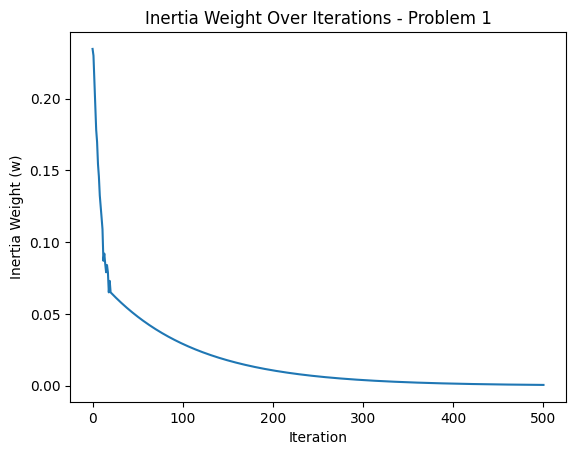

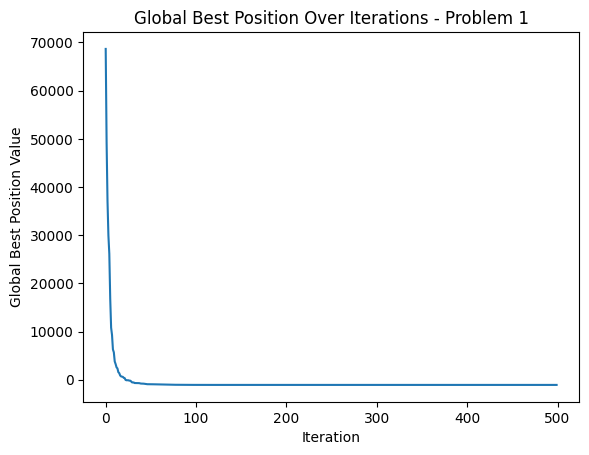




Problem 2 Best Cost: [-701.38756735 -701.41099906 -701.43346099 -701.44235125 -701.46672279
 -701.49841177 -701.52031625 -701.54888704 -701.54936254 -701.55675199
 -701.56966162 -701.60433401 -701.62085016 -701.62494053 -701.62494053
 -701.62826415 -701.66802752 -701.66802752 -701.67782644 -701.70705465
 -701.70705465 -701.73043494 -701.73043494 -701.73043494 -701.74521991
 -701.7601532  -701.78188741 -701.78188741 -701.78188741 -701.79191414
 -701.79788202 -701.79788202 -701.81422351 -701.81422351 -701.81520779
 -701.82326793 -701.82326793 -701.8239863  -701.8239863  -701.83375123
 -701.83375123 -701.83702898 -701.83702898 -701.85078521 -701.85078521
 -701.85078521 -701.86277877 -701.882499   -701.882499   -701.882499
 -701.882499   -701.882499   -701.882499   -701.882499   -701.88430088
 -701.89225237 -701.912106   -701.912106   -701.91503334 -701.91503334
 -701.91503334 -701.92684246 -701.92684246 -701.92684246 -701.93454699
 -701.93454699 -701.93454699 -701.94298319 -701.9429831

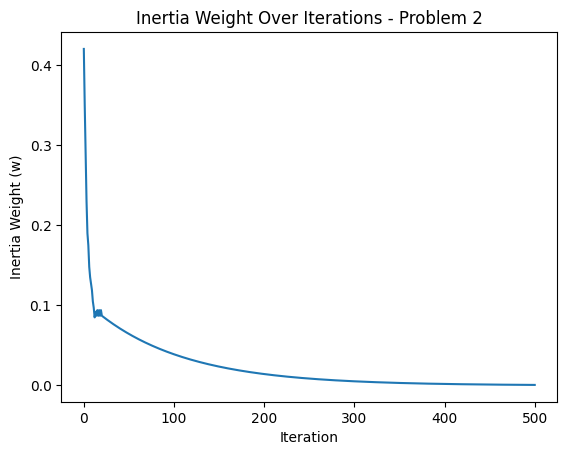

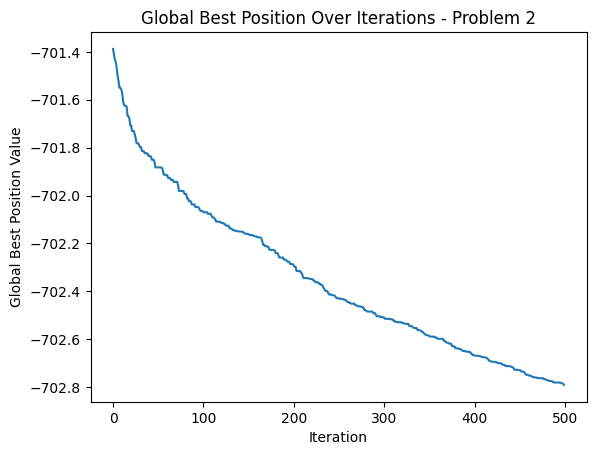




Problem 3 Best Cost: [ 2.54959806e+10  2.07737197e+10  1.96804742e+10  1.36619117e+10
  1.23805199e+10  8.88454382e+09  5.59047365e+09  4.59296404e+09
  4.59296404e+09  3.75125634e+09  3.05843337e+09  1.96226155e+09
  1.66501509e+09  1.58041973e+09  1.44269504e+09  1.34423336e+09
  1.31643501e+09  1.05769615e+09  9.33741629e+08  9.13956961e+08
  7.41988590e+08  7.33687104e+08  5.32863041e+08  5.20342468e+08
  5.14547676e+08  5.14547676e+08  4.07028542e+08  3.90720434e+08
  3.29047802e+08  3.12071987e+08  2.13408978e+08  2.13408978e+08
  2.13408978e+08  2.13408978e+08  2.07494991e+08  1.76915872e+08
  1.76915872e+08  1.76915872e+08  1.56857505e+08  1.13102586e+08
  1.13102586e+08  8.05984318e+07  5.87565790e+07  5.87565790e+07
  5.87565790e+07  5.41982851e+07  5.16331093e+07  3.64750993e+07
  3.64750993e+07  3.64750993e+07  3.37074450e+07  3.37074450e+07
  3.37074450e+07  3.37074450e+07  2.76017744e+07  2.71646284e+07
  2.71646284e+07  2.71646284e+07  2.65367561e+07  2.42953039e+07
 

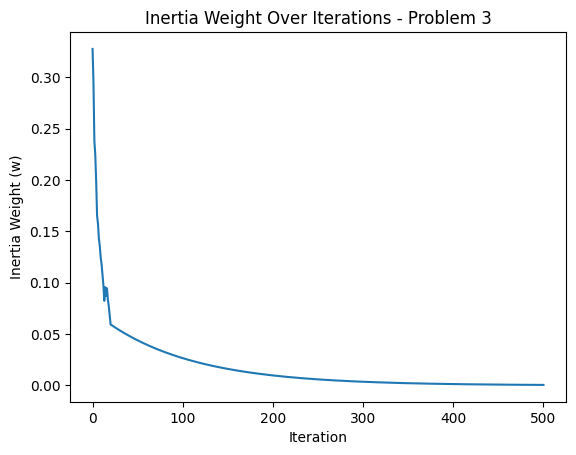

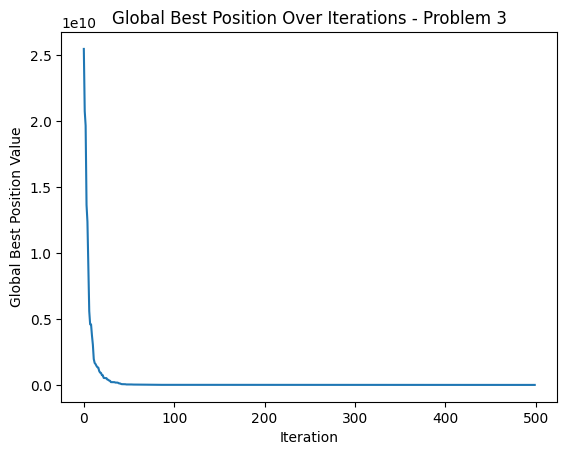




Problem 4 Best Cost: [ 3.89113598e+05  2.71134876e+05  2.07652469e+05  1.65257608e+05
  1.22386022e+05  9.84036500e+04  7.72282087e+04  5.83455019e+04
  5.83455019e+04  5.30560604e+04  4.64233112e+04  4.00490702e+04
  3.30046451e+04  2.45885280e+04  2.41561210e+04  1.71823737e+04
  1.59199210e+04  1.29994950e+04  8.48619706e+03  7.27170711e+03
  5.69885458e+03  5.69885458e+03  5.66850403e+03  5.66850403e+03
  4.55064930e+03  2.35182498e+03  2.35182498e+03  2.35182498e+03
  2.31613651e+03  2.25026563e+03  2.16214107e+03  1.65862263e+03
  1.65862263e+03  1.33525223e+03  1.33525223e+03  1.33525223e+03
  1.33525223e+03  1.33525223e+03  1.00384210e+03  1.00384210e+03
  8.07671443e+02  8.07671443e+02  8.07671443e+02  7.92213913e+02
  6.61276246e+02  6.61276246e+02  5.20395938e+02  3.37673112e+02
  2.79269257e+02  2.79269257e+02  2.79269257e+02  2.25021277e+02
  2.25021277e+02  1.49280960e+02  9.42470659e+01  1.87418548e+01
  1.87418548e+01 -1.42433650e+02 -1.67283686e+02 -1.67283686e+02
 

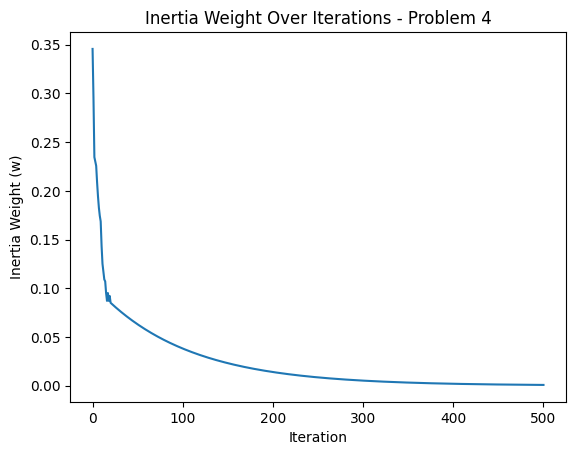

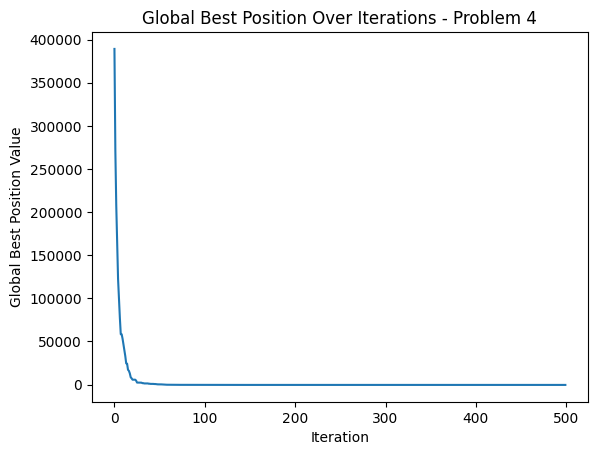




Problem 5 Best Cost: [-334.15434503 -334.20477868 -334.23314553 -334.29869842 -334.35734197
 -334.44970716 -334.47813536 -334.50432877 -334.51857358 -334.53432176
 -334.55810973 -334.57591698 -334.61414135 -334.63608076 -334.67186554
 -334.69572842 -334.7047867  -334.7497186  -334.7497186  -334.75788391
 -334.7843119  -334.7843119  -334.7843119  -334.80207282 -334.80207282
 -334.81083102 -334.8213     -334.83176874 -334.83834253 -334.83834253
 -334.83834253 -334.85285875 -334.89709394 -334.89709394 -334.89709394
 -334.89726457 -334.90365049 -334.90365049 -334.94407015 -334.94407015
 -334.95566608 -334.98073339 -334.99907606 -334.99907606 -334.99907606
 -335.00892389 -335.04031139 -335.05323202 -335.05323202 -335.06992515
 -335.06992515 -335.06992515 -335.06992515 -335.06992515 -335.07350812
 -335.08259118 -335.08259118 -335.10874285 -335.10874285 -335.10874285
 -335.11375822 -335.1315558  -335.14033205 -335.14033205 -335.14033205
 -335.14033205 -335.14229441 -335.16377157 -335.16377

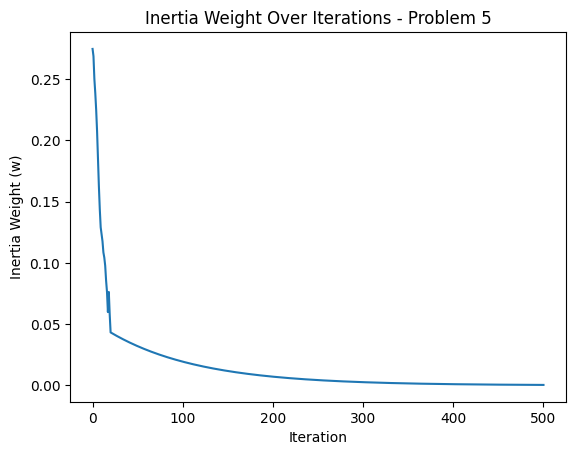

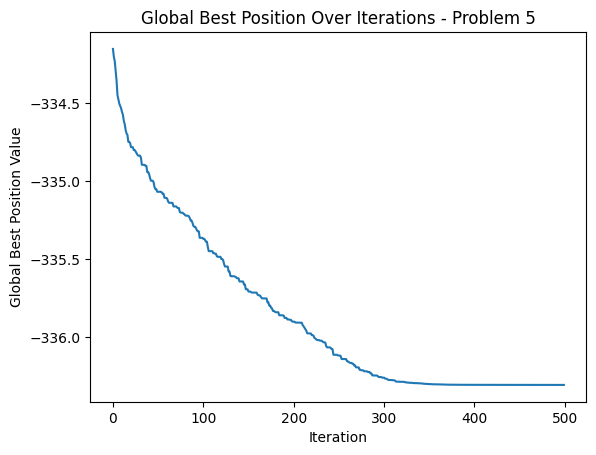




Problem 6 Best Cost: [-183.56909946 -183.60004747 -183.67516441 -183.69957111 -183.75450789
 -183.79303999 -183.81763134 -183.8568002  -183.87511989 -183.9461594
 -184.00321066 -184.00321066 -184.00321066 -184.06273762 -184.06273762
 -184.0696812  -184.07033185 -184.10098999 -184.1054078  -184.10583898
 -184.16952569 -184.16952569 -184.17470904 -184.17470904 -184.18576294
 -184.22733733 -184.24155922 -184.26423528 -184.28442215 -184.28442215
 -184.28442215 -184.30747303 -184.30989791 -184.30989791 -184.30989791
 -184.33620202 -184.33737659 -184.33737659 -184.34848006 -184.34848006
 -184.37266461 -184.3764346  -184.3764346  -184.39597724 -184.39597724
 -184.40538376 -184.40538376 -184.40538376 -184.40538376 -184.40585067
 -184.41053565 -184.41053565 -184.41461289 -184.4657704  -184.4657704
 -184.4657704  -184.46826818 -184.46826818 -184.47358796 -184.47840794
 -184.49317335 -184.50071006 -184.509801   -184.52038422 -184.52527989
 -184.52527989 -184.52527989 -184.52527989 -184.5269812

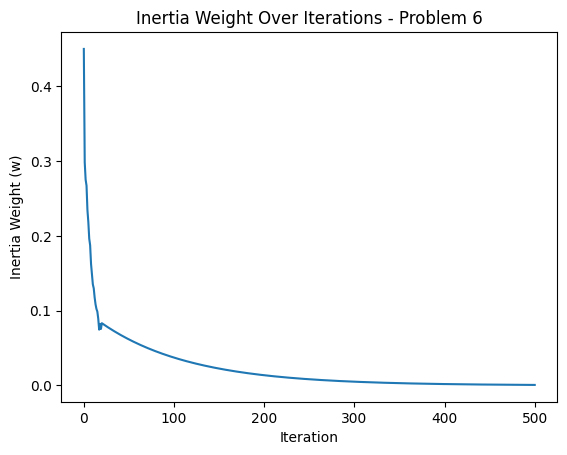

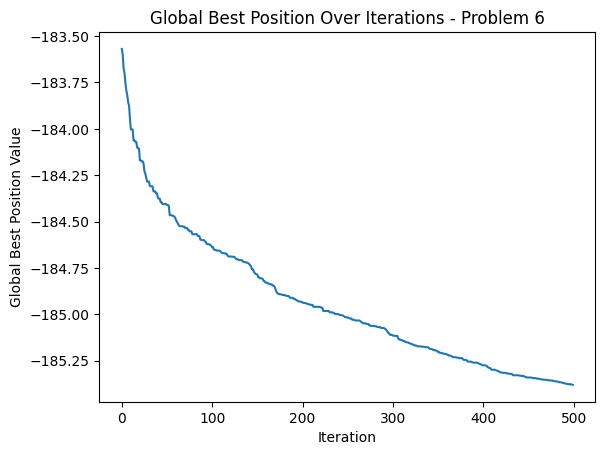




Problem 7 Best Cost: [81574.42278894 51641.05196641 45903.59601404 33417.93126725
 31264.92995602 24360.03959209 15667.1585822   8909.83699463
  8863.35292281  8033.78048267  8033.78048267  8033.78048267
  7387.45421649  6043.9893102   3942.96372767  3431.91471729
  3431.91471729  3406.33584557  1814.08119473  1814.08119473
  1634.29026575  1627.37953523  1495.29308579  1168.66097799
  1010.47231661  1010.47231661   573.7950358    573.7950358
   573.7950358    573.7950358    573.7950358    573.7950358
   527.33238861   462.01056508   202.01873249   194.48901913
   194.48901913   194.48901913  -131.84940592  -131.84940592
  -131.84940592  -155.67238093  -224.57656035  -334.0058814
  -334.0058814   -334.0058814   -334.0058814   -433.88975111
  -433.88975111  -433.88975111  -452.20599419  -466.11753273
  -466.11753273  -466.11753273  -466.11753273  -531.91938656
  -531.91938656  -531.91938656  -531.91938656  -537.5269459
  -594.12100225  -622.81468953  -622.81468953  -622.81468953
  -6

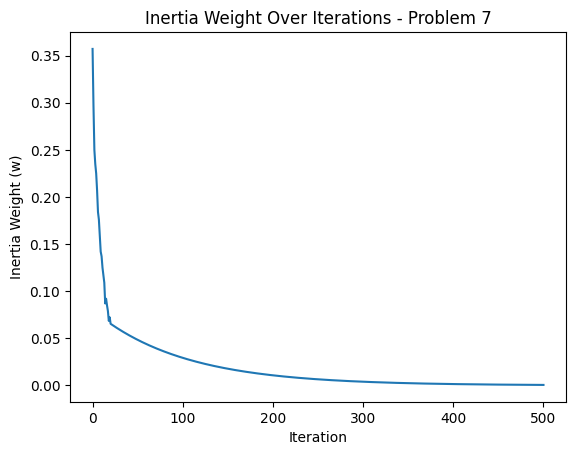

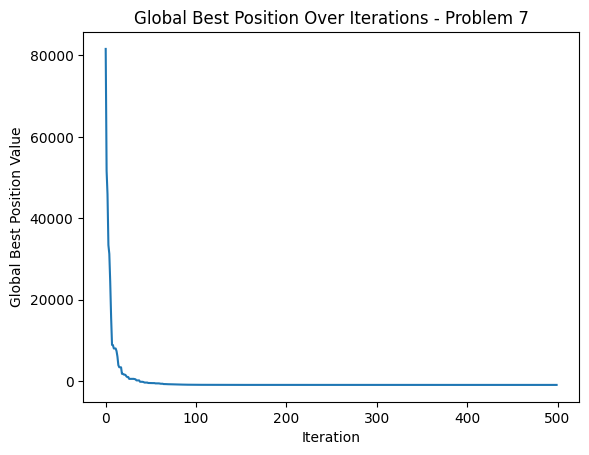




Problem 8 Best Cost: [56664.25038316 42047.99427936 40188.14305743 33037.03604503
 25160.24083508 25160.24083508 25160.24083508 25160.24083508
 25160.24083508 21259.85725533 20759.00900977 17798.23995884
  9530.76048672  9530.76048672  9530.76048672  8558.5635676
  7886.02433466  5974.76096176  4664.43487433  3848.92887888
  3848.92887888  3848.92887888  3651.12353064  3651.12353064
  2670.13981542  1902.88040493  1902.88040493  1358.63841879
  1358.63841879  1358.63841879  1358.63841879  1358.63841879
  1194.3240037   1194.3240037   1194.3240037   1194.3240037
   927.78146069   927.78146069   927.78146069   675.91710269
   623.82866179   438.97039859   438.97039859   438.97039859
   438.97039859   438.97039859   359.6879856    163.62462116
   151.64772426   151.64772426   -84.30206151   -84.30206151
   -84.30206151   -84.30206151   -84.30206151   -84.30206151
   -84.30206151   -94.58613482  -108.56490654  -115.84261471
  -115.84261471  -115.84261471  -115.84261471  -115.84261471
  

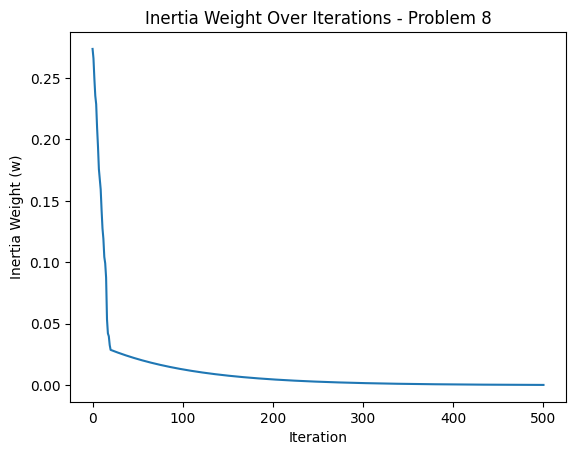

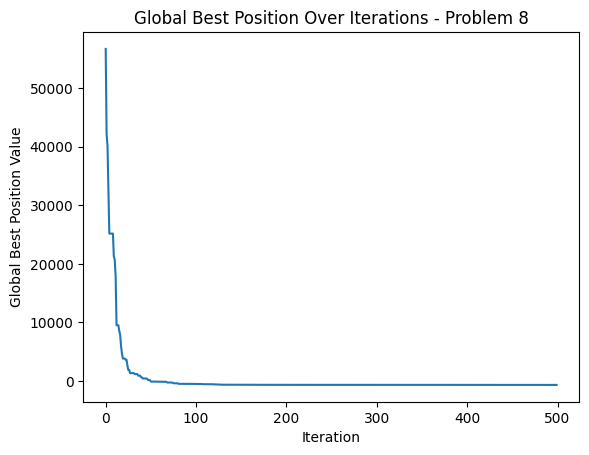




Problem 9 Best Cost: [3.28101842e+05 5.53167551e+04 5.53167551e+04 5.53167551e+04
 5.53167551e+04 5.53167551e+04 5.53167551e+04 5.53167551e+04
 5.53167551e+04 5.53167551e+04 5.53167551e+04 5.53167551e+04
 5.41333559e+04 5.41333559e+04 3.28476150e+04 3.28476150e+04
 3.28476150e+04 2.81312767e+04 2.81312767e+04 2.81312767e+04
 1.36044710e+04 1.36044710e+04 1.36044710e+04 1.36044710e+04
 1.36044710e+04 1.36044710e+04 1.36044710e+04 1.36044710e+04
 1.09024156e+04 1.09024156e+04 1.09024156e+04 1.09024156e+04
 1.09024156e+04 1.04175368e+04 1.04175368e+04 1.04175368e+04
 1.04175368e+04 9.91634088e+03 9.91634088e+03 9.91634088e+03
 9.91634088e+03 9.91634088e+03 9.13711998e+03 9.13711998e+03
 9.13711998e+03 9.13711998e+03 9.13711998e+03 9.13711998e+03
 9.13711998e+03 9.13711998e+03 7.53210380e+03 7.53210380e+03
 7.53210380e+03 7.53210380e+03 6.81787096e+03 6.81787096e+03
 6.81787096e+03 6.81787096e+03 6.31268322e+03 6.31268322e+03
 4.60437363e+03 3.75305500e+03 3.75305500e+03 3.75305500e+03


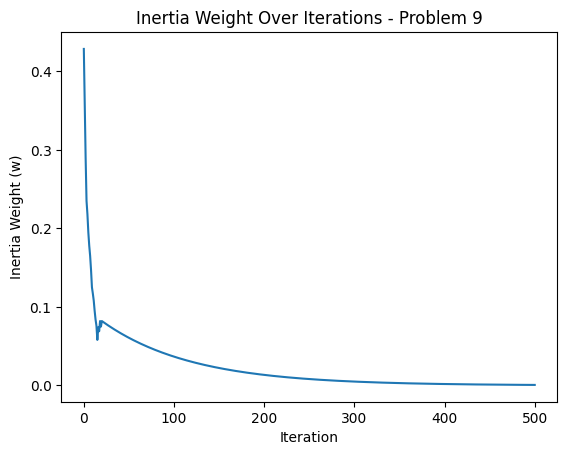

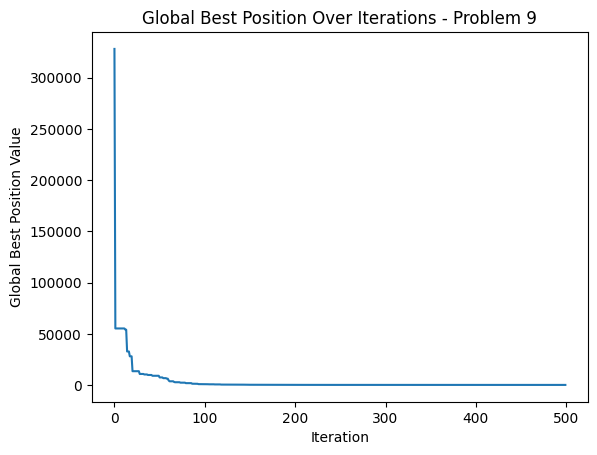




Problem 10 Best Cost: [73597.50061271 48963.23361721 29591.48041192 29591.48041192
 29591.48041192 23584.84132881 21435.89836749 21435.89836749
 21435.89836749 21435.89836749 19510.10132052 19510.10132052
 19510.10132052 17823.55034169 17823.55034169 15689.20720928
 15689.20720928 14425.27936015 14252.60613881 14252.60613881
 13733.5282344  13733.5282344  11523.45295943 11388.71701133
 11388.71701133  9542.84988913  7881.9691342   7881.9691342
  7881.9691342   7881.9691342   7881.9691342   6887.67927797
  6356.50173502  6356.50173502  6355.56596737  5058.81970922
  5058.81970922  5058.81970922  5058.81970922  4926.50439295
  4926.50439295  4926.50439295  4221.56811688  4221.56811688
  4221.56811688  4184.27429955  4184.27429955  3905.45947435
  3905.45947435  3905.45947435  3905.45947435  3822.58419419
  3325.04541272  3241.13099344  3110.48149066  3110.48149066
  3026.25807234  3026.25807234  3026.25807234  3026.25807234
  3026.25807234  3008.24127342  3008.24127342  2945.58464105


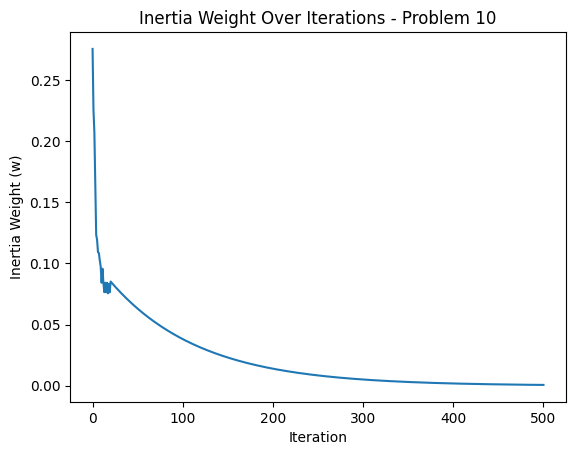

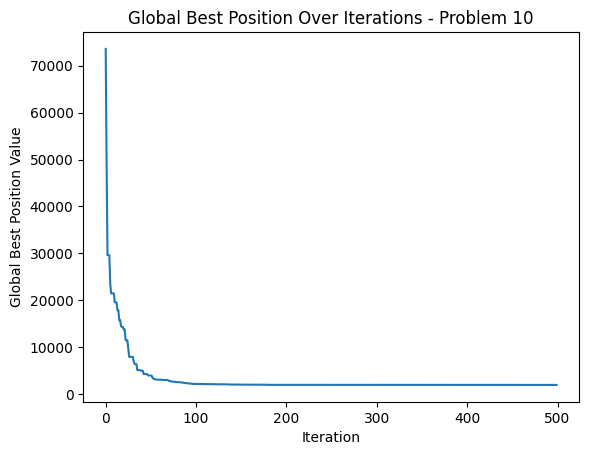




Problem 11 Best Cost: [84183.61476507 66287.92956607 47745.64598566 36672.30495076
 25400.42687615 25400.42687615 25400.42687615 25400.42687615
 25400.42687615 25400.42687615 25400.42687615 20697.71228571
 20697.71228571 20697.71228571 20697.71228571 20697.71228571
 20697.71228571 20697.71228571 20697.71228571 20697.71228571
 19127.21521267 17622.36274898 17622.36274898 17622.36274898
 17622.36274898 17148.59449629 17148.59449629 17148.59449629
 17148.59449629 17148.59449629 17148.59449629 17148.59449629
 17148.59449629 17148.59449629 16826.26507465 16826.26507465
 16826.26507465 16826.26507465 16609.94362225 16609.94362225
 16220.19438408 16220.19438408 16160.36223747 16160.36223747
 16160.36223747 15697.85175797 15697.85175797 15697.85175797
 15644.18938045 15644.18938045 15626.04294402 15626.04294402
 15620.67867446 15620.67867446 15349.15736476 15349.15736476
 15176.33992928 14969.94027641 14969.94027641 14969.94027641
 14969.94027641 14969.94027641 14969.94027641 14957.04153753

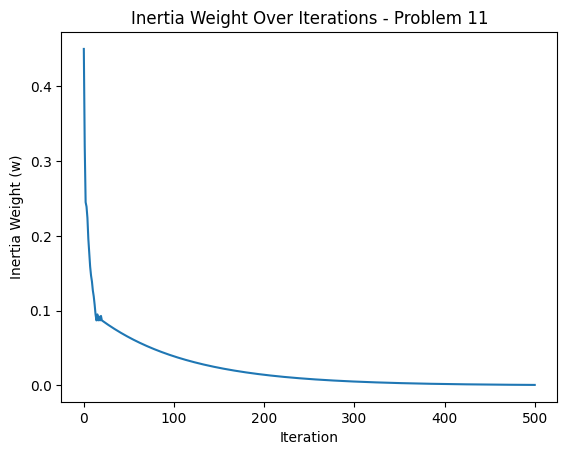

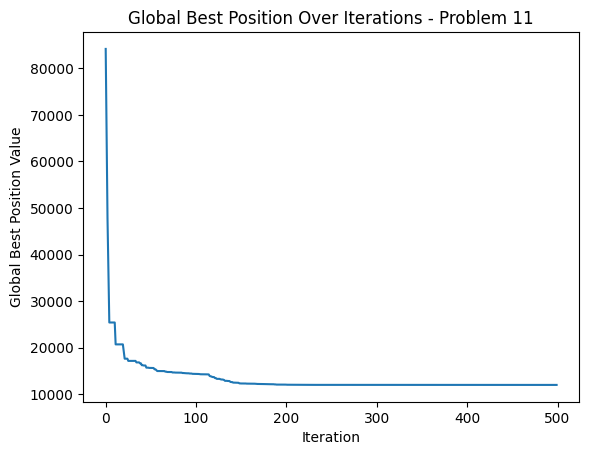




Problem 12 Best Cost: [55318.42465311 55318.42465311 50416.44411435 34888.31052067
 30216.33292447 29511.56717818 22460.60607355 21307.94710025
 21307.94710025 21307.94710025 20409.36393397 17237.39296374
 17237.39296374 17237.39296374 17237.39296374 13325.3868265
 13325.3868265  13325.3868265  11713.70587296 11713.70587296
 11713.70587296 11226.01634119 11226.01634119 11226.01634119
 11226.01634119 11226.01634119 10593.79315739 10593.79315739
  9458.75545686  8469.21983632  8158.15756638  8158.15756638
  8158.15756638  7909.60433646  7909.60433646  7400.7796396
  7299.75054697  7299.75054697  7299.75054697  6663.65081931
  5948.32313559  5948.32313559  5948.32313559  5948.32313559
  5948.32313559  5948.32313559  5948.32313559  5948.32313559
  5948.32313559  5948.32313559  5948.32313559  5948.32313559
  5948.32313559  5948.32313559  5948.32313559  5948.32313559
  5948.32313559  5948.32313559  5948.32313559  5948.32313559
  5948.32313559  5948.32313559  5948.32313559  5183.29007599
 

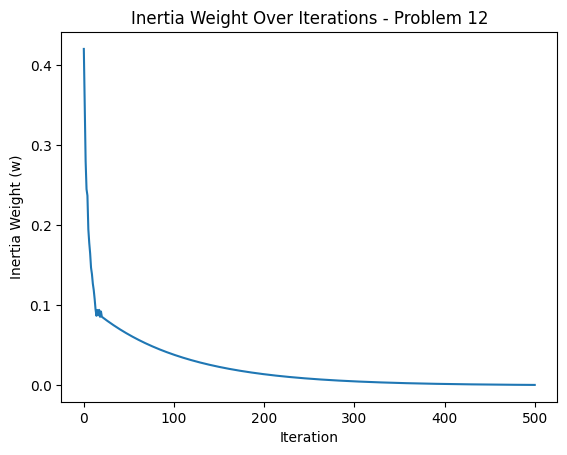

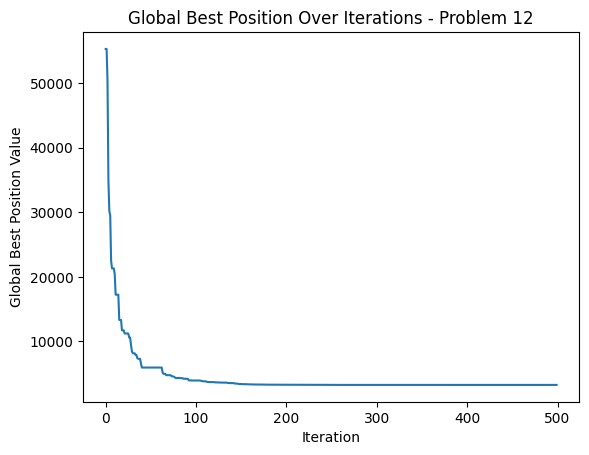




Problem 13 Best Cost: [316540.60066653 195822.37602224 117930.87306851 117930.87306851
  92754.85445389  92754.85445389  92754.85445389  92754.85445389
  92754.85445389  92754.85445389  92754.85445389  92754.85445389
  92754.85445389  92754.85445389  81767.8490737   81767.8490737
  81767.8490737   81767.8490737   81767.8490737   81767.8490737
  81767.8490737   81767.8490737   81767.8490737   81767.8490737
  81767.8490737   81767.8490737   81767.8490737   81767.8490737
  81767.8490737   81767.8490737   81767.8490737   81767.8490737
  81767.8490737   81767.8490737   81767.8490737   81767.8490737
  81767.8490737   19294.72527381  19294.72527381  19294.72527381
  19294.72527381  19294.72527381  19294.72527381  19294.72527381
  19294.72527381  19294.72527381  19294.72527381  19294.72527381
  19294.72527381  19294.72527381  19294.72527381  19294.72527381
  19294.72527381  19294.72527381  19294.72527381  19294.72527381
  19294.72527381  19294.72527381  19294.72527381  19294.72527381
  1929

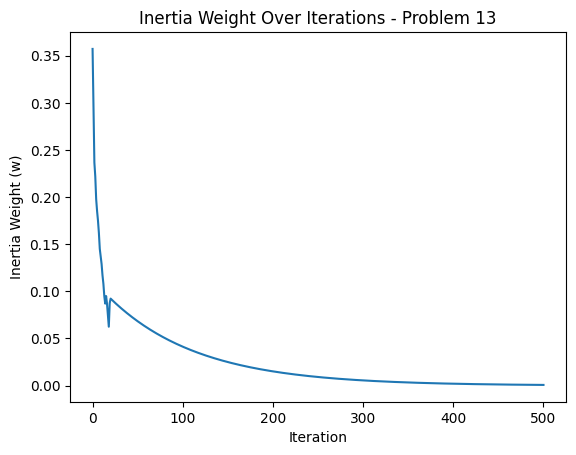

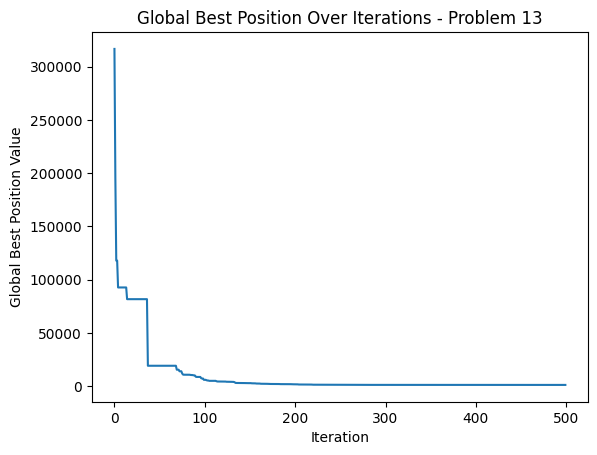




Problem 14 Best Cost: [35459.92594506 35459.92594506 31182.99378975 27846.12534155
 22172.15646738 22172.15646738 22172.15646738 22172.15646738
 21254.98740325 21254.98740325 21254.98740325 21254.98740325
 21254.98740325 21246.00298065 21246.00298065 21193.31958638
 21168.24571942 21168.24571942 20684.82773833 20684.82773833
 20376.55798702 20376.55798702 20376.55798702 20376.55798702
 20376.55798702 20376.55798702 20376.55798702 20376.55798702
 20376.55798702 20376.55798702 20376.55798702 20376.55798702
 20376.55798702 20376.55798702 20376.55798702 20376.55798702
 20376.55798702 20376.55798702 19377.55773588 19377.55773588
 19377.55773588 19377.55773588 19233.00527208 18713.92223822
 18713.92223822 18713.92223822 18713.92223822 18713.92223822
 18713.92223822 18573.4311253  17267.72965297 17267.72965297
 17267.72965297 16785.35191901 16785.35191901 16785.35191901
 16785.35191901 16299.23730723 16299.23730723 16299.23730723
 16299.23730723 16299.23730723 16299.23730723 16299.23730723

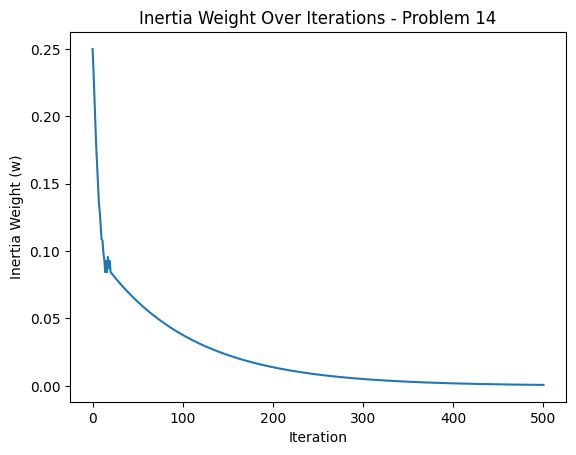

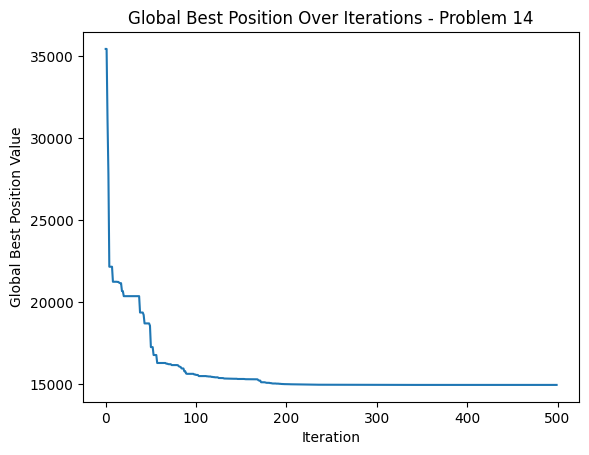




Problem 15 Best Cost: [-224.70251672 -225.56409934 -225.56409934 -225.56409934 -225.56409934
 -225.56409934 -225.56409934 -225.56409934 -225.56409934 -225.90142952
 -225.90142952 -225.92657928 -226.19333595 -226.19333595 -226.45206462
 -226.45206462 -226.45206462 -226.65221716 -226.65221716 -226.65221716
 -227.09051678 -227.09051678 -227.09051678 -227.09051678 -227.09051678
 -227.09051678 -227.09051678 -227.09051678 -227.37636155 -227.37636155
 -227.37636155 -227.37636155 -227.41196276 -227.41196276 -227.42654719
 -227.42654719 -227.44155886 -227.46070653 -227.46070653 -227.46070653
 -227.46070653 -227.4679264  -227.6193382  -227.6193382  -227.6193382
 -227.70455138 -227.70455138 -227.70455138 -227.70455138 -227.70455138
 -227.70455138 -227.70455138 -227.70455138 -227.76618436 -227.82912979
 -227.82912979 -227.87921429 -227.9017161  -227.90267454 -227.90267454
 -227.90267454 -227.90267454 -227.94174912 -227.95302507 -227.95302507
 -228.01129296 -228.01129296 -228.01129296 -228.01129

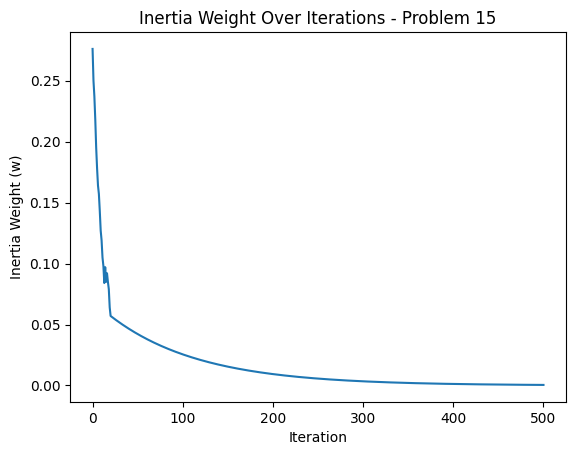

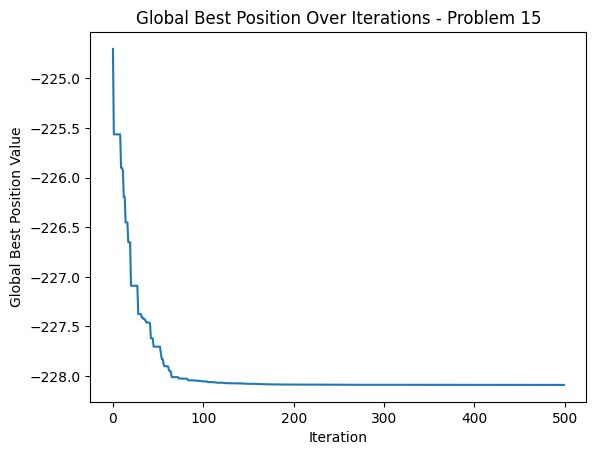




Problem 16 Best Cost: [52810.66700962 39954.11613363 39954.11613363 30361.39465584
 20424.11772414 10977.53537437  4687.9872589   3893.78860585
  2902.26013483   972.7314578  -2044.08202401 -2331.91053069
 -2596.72357952 -2723.95264907 -3286.76536353 -3436.93948161
 -3740.29953164 -3898.95922204 -4008.58729178 -4059.1000779
 -4243.95415528 -4296.41376075 -4393.26507097 -4466.18838957
 -4466.18838957 -4517.59358341 -4732.63308829 -4732.63308829
 -4732.63308829 -4751.9277484  -4757.68943958 -4804.94349982
 -4804.94349982 -4833.87863724 -4833.87863724 -4839.84368533
 -4839.84368533 -4883.24159715 -4883.24159715 -4883.24159715
 -4883.24159715 -4883.24159715 -4883.24159715 -4897.8179819
 -4911.36653869 -4911.36653869 -4933.09047376 -4933.09047376
 -4933.74795727 -4933.74795727 -4933.74795727 -4940.73992436
 -4944.26508735 -4944.26508735 -4944.26508735 -4944.26508735
 -4944.26508735 -4950.3714204  -4950.3714204  -4950.3714204
 -4961.47860693 -4961.47860693 -4961.47860693 -4964.53697142
 -

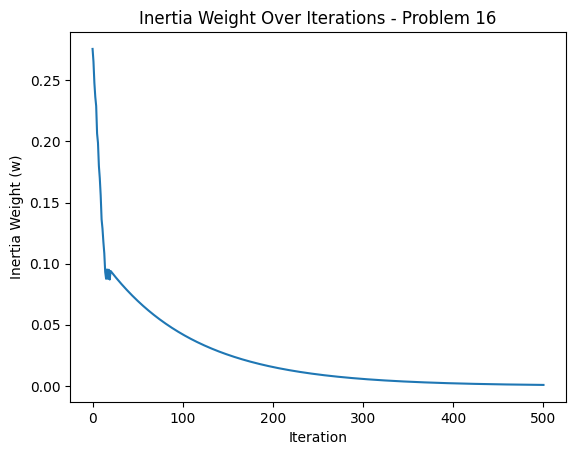

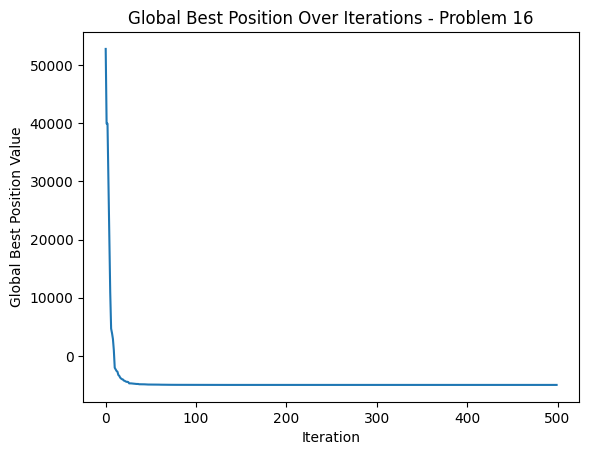




Problem 17 Best Cost: [ 1.85443815e+06  1.83574908e+06  1.44165275e+06  1.22584677e+06
  9.02568005e+05  5.77611141e+05  4.10934219e+05  3.44996250e+05
  3.41575858e+05  2.35266154e+05  1.70193640e+05  1.66979764e+05
  1.17191304e+05  1.14039734e+05  1.01536756e+05  8.79566983e+04
  8.22952661e+04  7.43307235e+04  5.64966901e+04  5.36277189e+04
  3.83179820e+04  2.62895941e+04  2.62895941e+04  2.62895941e+04
  2.35202070e+04  2.35202070e+04  2.35202070e+04  2.35202070e+04
  2.16573416e+04  2.16573416e+04  2.16573416e+04  2.11676420e+04
  1.97579685e+04  1.97579685e+04  1.97579685e+04  1.89761928e+04
  1.86988337e+04  1.81324335e+04  1.81324335e+04  1.81324335e+04
  1.69722781e+04  1.69722781e+04  1.58298555e+04  1.58298555e+04
  1.56654913e+04  1.41467002e+04  1.41467002e+04  1.41467002e+04
  1.15469438e+04  1.15469438e+04  1.11122577e+04  1.11122577e+04
  1.11122577e+04  1.11122577e+04  1.11122577e+04  1.11122577e+04
  1.11122577e+04  1.09599886e+04  1.05017898e+04  9.23915030e+03


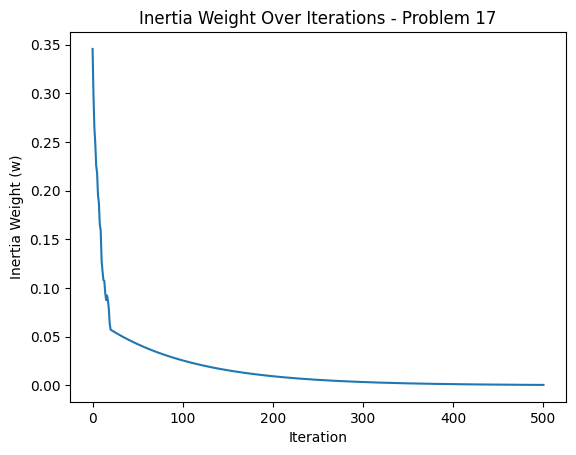

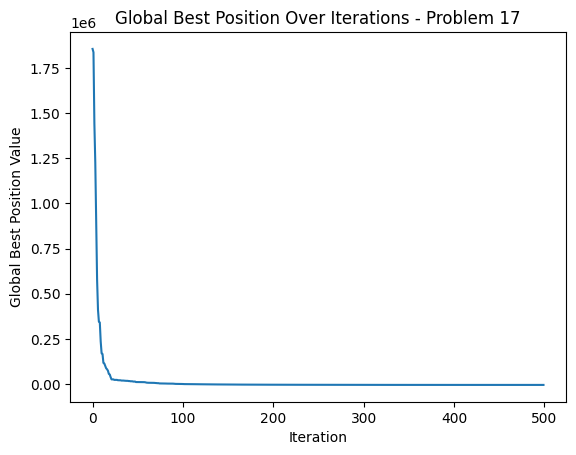




Problem 18 Best Cost: [ 5.89820942e+04  3.87028071e+04  3.87028071e+04  3.49386870e+04
  2.64422390e+04  2.09185231e+04  1.88229774e+04  1.68823819e+04
  1.23357743e+04  1.23357743e+04  1.11870170e+04  1.11870170e+04
  1.10300457e+04  1.10300457e+04  1.10300457e+04  1.10300457e+04
  1.10300457e+04  1.10300457e+04  1.10300457e+04  1.10300457e+04
  1.10300457e+04  1.03796728e+04  1.03167945e+04  9.91140706e+03
  9.91140706e+03  9.91140706e+03  9.91140706e+03  9.91140706e+03
  9.91140706e+03  8.70836340e+03  8.70836340e+03  8.70836340e+03
  8.24094550e+03  8.24094550e+03  8.24094550e+03  7.64382403e+03
  7.64382403e+03  7.61614207e+03  7.61614207e+03  7.61614207e+03
  7.00512281e+03  4.53439619e+03  4.53439619e+03  4.53439619e+03
  4.53439619e+03  3.17714913e+03  3.17714913e+03  3.17714913e+03
  3.17714913e+03  3.17714913e+03  2.59407399e+03  2.59407399e+03
  2.59407399e+03  2.59407399e+03  2.59407399e+03  2.59407399e+03
  2.59407399e+03  2.59407399e+03  2.59407399e+03  2.59407399e+03


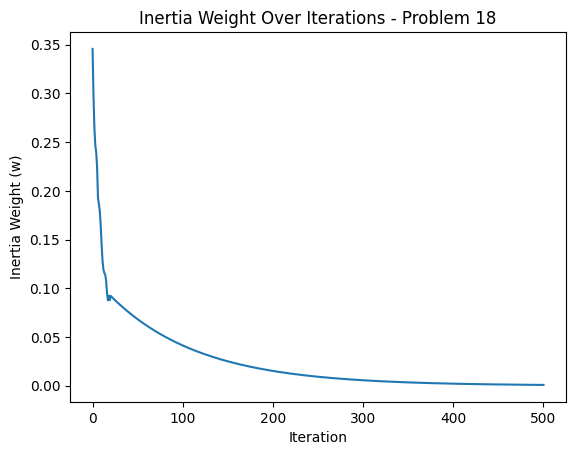

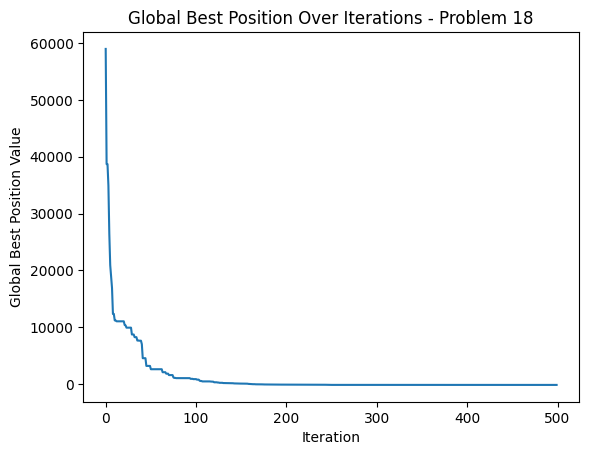




Problem 19 Best Cost: [ 5.31002631e+04  4.85137612e+04  4.18586618e+04  4.18586618e+04
  4.14605807e+04  4.04741714e+04  4.04741714e+04  4.04741714e+04
  3.68536440e+04  3.03399040e+04  3.03399040e+04  2.95495695e+04
  2.62980298e+04  2.29619927e+04  1.88524183e+04  1.47507321e+04
  1.02601167e+04  7.62277661e+03  7.62277661e+03  7.62277661e+03
  7.62277661e+03  7.62277661e+03  7.62277661e+03  7.62277661e+03
  7.62277661e+03  7.62277661e+03  7.62277661e+03  7.62277661e+03
  7.62277661e+03  7.62277661e+03  7.62277661e+03  7.62277661e+03
  6.45377898e+03  6.45377898e+03  6.45377898e+03  5.66241004e+03
  5.66241004e+03  5.66241004e+03  5.66241004e+03  5.66241004e+03
  5.66241004e+03  5.66241004e+03  5.66241004e+03  5.66241004e+03
  5.56903641e+03  5.56903641e+03  4.35001762e+03  4.35001762e+03
  4.35001762e+03  4.35001762e+03  4.35001762e+03  3.67964556e+03
  3.67964556e+03  3.67964556e+03  3.67964556e+03  3.67964556e+03
  3.67964556e+03  3.67964556e+03  3.67964556e+03  3.67964556e+03


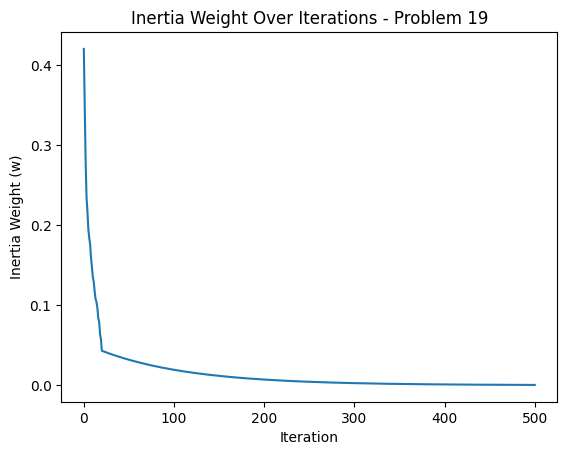

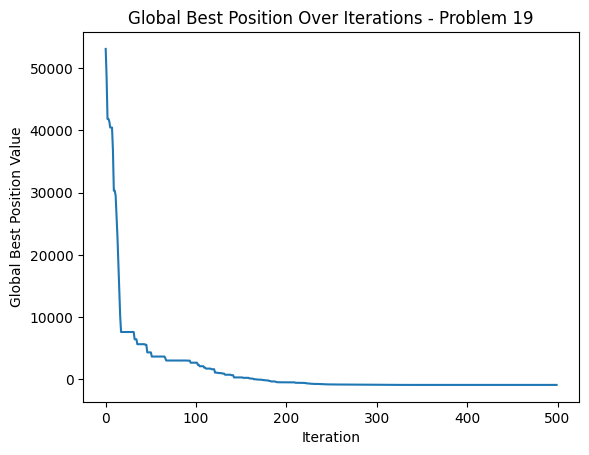




Problem 20 Best Cost: [-83.64336734 -83.92074173 -85.66493647 -86.80236901 -86.80236901
 -86.80236901 -86.80236901 -86.80236901 -87.00483701 -87.00483701
 -87.01355454 -87.63896565 -87.71849052 -87.71849052 -87.92028308
 -88.02277454 -88.18127687 -88.18127687 -88.18127687 -88.18127687
 -88.18127687 -88.18127687 -88.32752651 -88.32752651 -88.32752651
 -88.32752651 -88.32752651 -88.32752651 -88.32752651 -88.32752651
 -88.43987215 -88.73252738 -88.80202061 -89.16959523 -89.22486243
 -89.22486243 -89.22486243 -89.43553681 -89.60147631 -89.93125585
 -89.93125585 -90.22502876 -90.22502876 -90.22502876 -90.37207682
 -90.44653127 -90.44653127 -90.70860046 -90.70860046 -90.70860046
 -91.20602271 -91.20602271 -91.24669257 -91.24669257 -91.24669257
 -91.24669257 -91.24669257 -91.24669257 -91.24669257 -91.46020954
 -91.46020954 -91.46020954 -91.46020954 -91.56671564 -91.56671564
 -91.56671564 -91.56671564 -91.56671564 -91.81959366 -91.81959366
 -91.81959366 -91.81959366 -91.81959366 -91.8195936

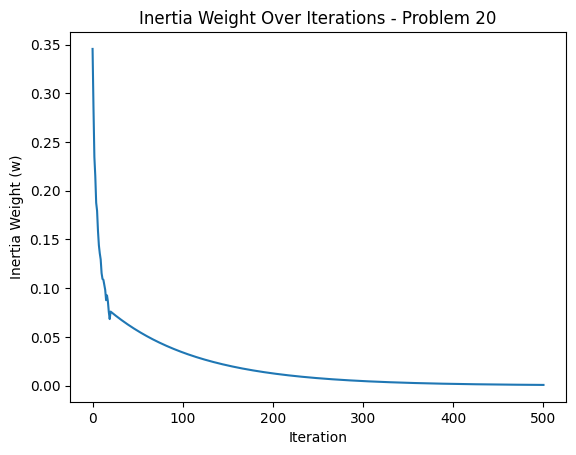

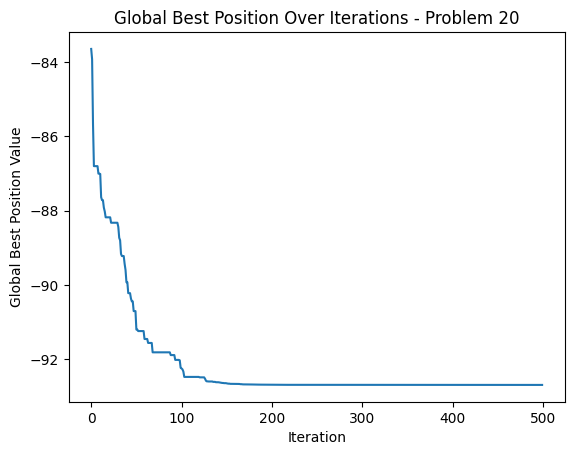




Problem 21 Best Cost: [131.67910688  85.79552659  52.55286661  27.38972372  23.70644377
   0.40254114   0.40254114  -2.67230858  -5.69628705  -5.69628705
 -12.28791198 -12.28791198 -15.12512413 -15.12512413 -15.12512413
 -18.13276208 -18.13276208 -18.13276208 -20.43955435 -21.86576052
 -26.28600187 -26.28600187 -26.28600187 -26.89290491 -26.89290491
 -26.89290491 -26.89290491 -27.58467876 -28.09671735 -28.48531681
 -29.62362238 -29.62362238 -29.62362238 -30.80761386 -30.80761386
 -30.80761386 -30.80761386 -30.80761386 -30.80761386 -30.80761386
 -31.29507675 -31.29507675 -32.21996303 -34.7140755  -34.7140755
 -34.7140755  -34.7140755  -34.7140755  -34.7140755  -34.7140755
 -34.7140755  -34.7140755  -34.72312958 -35.70879061 -35.70879061
 -35.70879061 -35.70879061 -35.70879061 -35.75988066 -35.9026356
 -35.9026356  -35.98256635 -36.00491244 -36.19211863 -36.19211863
 -36.99194124 -37.51349151 -37.51349151 -37.51704554 -37.51704554
 -37.51704554 -37.79643375 -37.90833759 -37.90833759 -

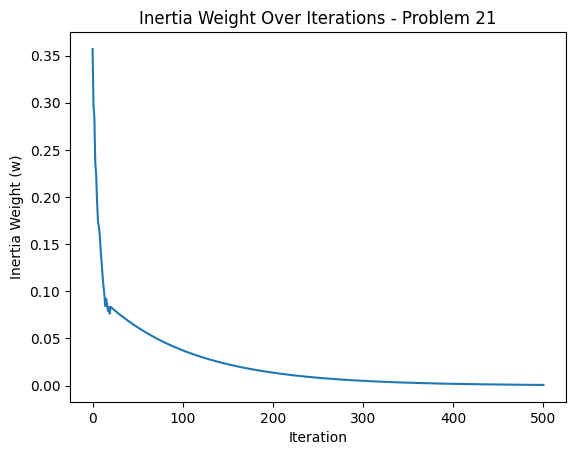

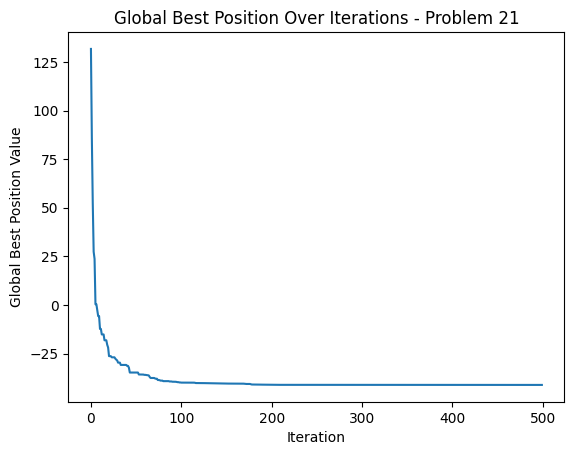




Problem 22 Best Cost: [316742.61649131 293477.49827614 236398.30774614 202129.16663534
 202129.16663534 146125.85176547 146125.85176547 146125.85176547
 146125.85176547 146125.85176547 146125.85176547 146125.85176547
 138930.1889323  132601.03341373 132601.03341373 132601.03341373
 132601.03341373 132601.03341373 132601.03341373 132601.03341373
 132601.03341373 132601.03341373 132601.03341373 132601.03341373
 132601.03341373 132601.03341373 128082.77524859 128082.77524859
 128082.77524859 128082.77524859 128082.77524859 128082.77524859
 128082.77524859 128082.77524859 128082.77524859 128082.77524859
 128082.77524859 128082.77524859 128082.77524859 124952.02806898
 124952.02806898 124952.02806898 124952.02806898 124952.02806898
 124952.02806898 124952.02806898 124952.02806898 124952.02806898
 124952.02806898 119569.03769927 119569.03769927 119569.03769927
 119569.03769927 119569.03769927 112332.90635555 112332.90635555
 112332.90635555 110910.86883104 110910.86883104 110910.86883104


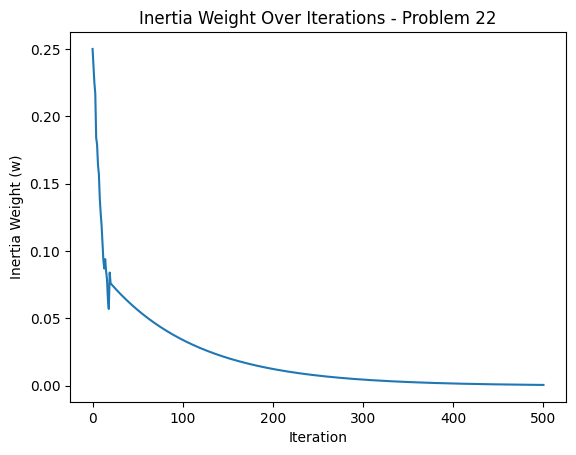

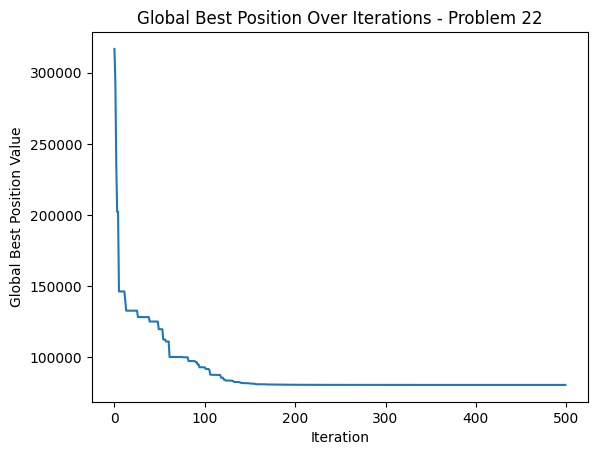




Problem 23 Best Cost: [-16.71359109 -28.8535633  -32.51974123 -38.87625777 -38.87625777
 -45.22061502 -45.22061502 -45.22061502 -45.22061502 -50.77928065
 -50.77928065 -50.77928065 -50.77928065 -50.77928065 -50.77928065
 -50.77928065 -50.77928065 -50.77928065 -50.77928065 -50.77928065
 -50.77928065 -50.77928065 -50.77928065 -52.84256233 -52.84256233
 -53.082137   -53.082137   -55.48461943 -55.48461943 -55.48461943
 -55.48461943 -55.48461943 -56.04608217 -56.04608217 -56.04608217
 -56.04608217 -56.21915476 -56.98881572 -56.98881572 -56.98881572
 -56.98881572 -56.98881572 -58.39371903 -58.39371903 -58.39371903
 -59.28098104 -59.28098104 -59.28098104 -59.28098104 -59.28098104
 -59.93354072 -60.10448275 -60.10448275 -60.10448275 -60.10448275
 -60.20363672 -60.20363672 -60.33525782 -60.56813603 -60.63410923
 -60.89007675 -61.02197743 -61.02197743 -61.02197743 -61.47768048
 -61.67769864 -61.67769864 -61.67769864 -61.67769864 -61.67769864
 -61.67769864 -61.67769864 -61.67769864 -61.6776986

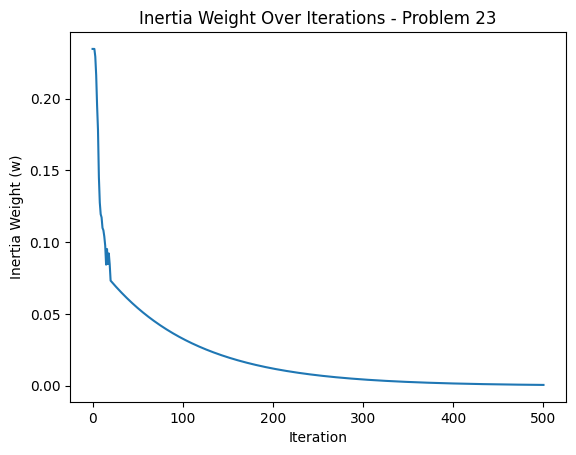

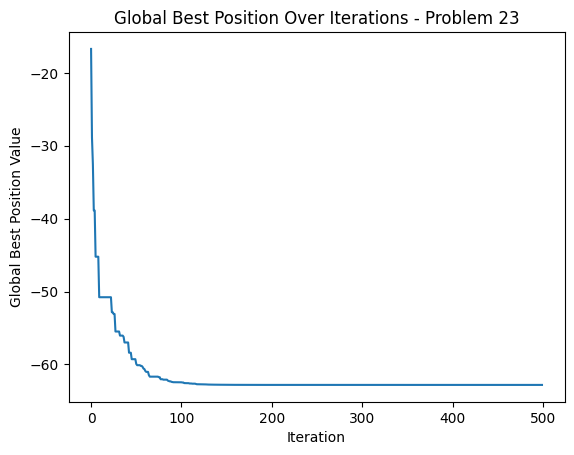




Problem 24 Best Cost: [132.7682422  101.58124925  71.59947218  71.59947218  71.59947218
  64.83134449  55.72585004  55.72585004  55.13439612  42.02246718
  42.02246718  42.02246718  42.02246718  41.89707099  33.94047928
  33.94047928  33.94047928  31.44024235  31.44024235  31.44024235
  29.02534406  28.96135084  28.96135084  27.78890851  27.78890851
  27.02460859  21.170654    21.170654    21.170654    21.170654
  21.170654    18.04261804  18.04261804  18.04261804  18.04261804
  18.04261804  18.04261804  16.82456165  16.82456165  13.19947095
  13.19947095   8.07903586   8.07903586   3.57924044   3.57924044
   3.57924044   3.57924044   3.57924044   3.57924044   3.57924044
   3.57924044   0.36317897  -4.11785463  -4.11785463  -4.11785463
  -4.11785463  -4.11785463  -4.11785463  -4.11785463  -4.11785463
  -8.97567234  -8.97567234 -11.28200375 -11.28200375 -11.28200375
 -11.28200375 -11.28200375 -11.28200375 -11.28200375 -11.38199237
 -12.12772123 -13.40066149 -13.40066149 -13.40066149 

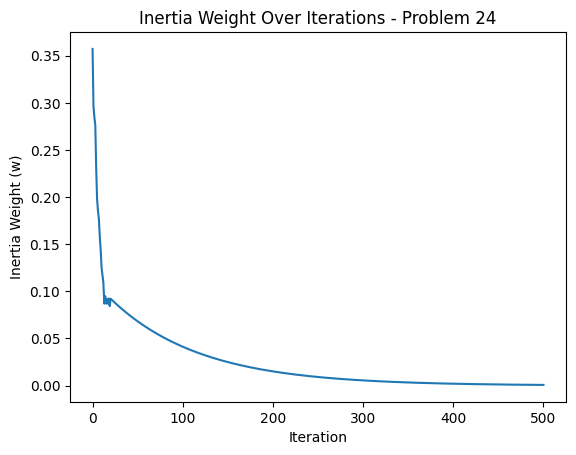

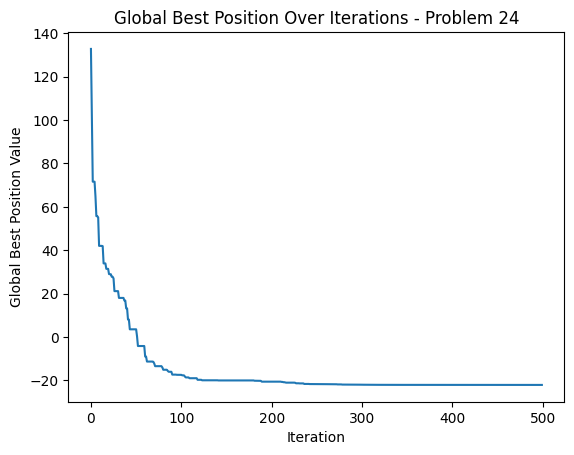

In [22]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]

    print("\n\n\nProblem", curr, "Best Cost:", problem_results['BestCost'])
    print("Problem", curr, "Best Position:", problem_results['BestPosition'])

    plt.plot(problem_results['w_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Inertia Weight (w)')
    plt.title(f'Inertia Weight Over Iterations - Problem {curr}')
    plt.show()

    plt.plot(problem_results['g_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Global Best Position Value')
    plt.title(f'Global Best Position Over Iterations - Problem {curr}')
    plt.show()

In [23]:
print('nice')

nice


In [24]:
print('almost complete')

almost complete


In [25]:
print("Don't disconnect runtime")

Don't disconnect runtime
